In [1]:
#import required package
from __future__ import division
from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import spectral.io.envi as envi
from spectral import *
import os
import re
import math
import PIL
from scipy import signal
from scipy import ndimage
from scipy import spatial
from scipy import stats
from scipy import interpolate
import traceback
import sys
import pickle
import warnings
import pandas as pd
from pprint import pprint
from sklearn.metrics import r2_score
#from osgeo import gdal
from pysptools import spectro
from collections import Counter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#file mangement generates a list containing a pth to all hdr files of pre-processed observations
def get_all_processed_HDR_addresses(parentDirectory):
    observationFiles=[]
    
    for (dirpath, dirnames, filenames) in os.walk(parentDirectory):
        observationFiles.extend(filenames)
        break
    ObservationImageAddresses=[]
    
    hdrPattern=".hdr"
    for i in observationFiles:
        if re.search(hdrPattern,i):
            ObservationImageAddresses.append(parentDirectory+'/'+i)
    return ObservationImageAddresses

In [3]:
#read hrd files for wavlengths of all bands
def read_CRISM_Image_wavelengths(headerFileAddress):
    wavelengthFile="J:/IIT/user/Documents/CRISM Multispectral Exploration/Processed_observations/wavelength_list.txt"
    
    currentObservationHeader=envi.open(headerFileAddress)
    currentObservationImage=currentObservationHeader.open_memmap()
    currentObservationArray=np.array(currentObservationImage)
    #currentObservationArray=spectral.open_image(i)

    #read wavelengths from saved wavelength file
    with open (wavelengthFile, 'rb') as fp:
        wavelengthsOfCurrentObservation=pickle.load(fp)
    return currentObservationArray,wavelengthsOfCurrentObservation

In [4]:
#find index of wavelngth closest to given wavelength
def find_nearest(wavelength_list,value): #find wavelength value in list closest to given value
    idx = np.searchsorted(wavelength_list, value, side="left")
    if idx > 0 and (idx == len(wavelength_list) or math.fabs(value - wavelength_list[idx-1]) < math.fabs(value - wavelength_list[idx])):
        return wavelength_list[idx-1]
    else:
        return wavelength_list[idx]

def find_wavelength_index(wavelength_list,item): #return index of in the array
    first = 0
    last = len(wavelength_list)-1
    found = False
    while( first<=last and not found):
        mid = (first + last)//2
        if wavelength_list[mid] == item :
            found = True
        else:
            if item < wavelength_list[mid]:
                last = mid - 1
            else:
                first = mid + 1	
    return mid
def find_nearest_index(wavelength_list,wavelength): #get wavelength in index closest to gicen wavelength and return its index
    (nearest_index,nearest_wavelength)=min(enumerate(wavelength_list), key=lambda x: abs(x[1]-wavelength))
    return nearest_index
def find_nearest_index_for_list(wavelength_list,wavelengths): # find index of nearest value for a list of given values
    indices=[]
    for i in wavelengths:
        indices.append(find_nearest_index(wavelength_list,i))
    return indices

In [5]:
# given a hyperspectral datacube and wavelengths to serve as upper and lower thresholds subset the datacube along the spectral direction
def get_spectral_subset(datacube,wavelength_list,lower_threshold,upper_threshold): #returns spectral subset from lower to upper threshold ( 1.2 to 2.6 micrometer for CRISM IR)
    lower_threshold_index=find_wavelength_index(wavelength_list,lower_threshold)
    upper_threshold_index=find_wavelength_index(wavelength_list,upper_threshold)
    thresholdedDatacube=datacube[:,:,lower_threshold_index:upper_threshold_index+1]
    thresholdedWavelengthList=wavelength_list[lower_threshold_index:upper_threshold_index+1]
    return thresholdedDatacube,thresholdedWavelengthList

In [6]:
# return an array of objects of SLI files corresponding to different mineral spectra
def getspectralObjects(spectraDirectory):
    observationFiles=[]
    for (_,_,temporaryList) in os.walk(spectraDirectory):
        observationFiles.extend(temporaryList)
        break
    hdrPattern=".hdr$"
    spectralObjects=[]
    for i in observationFiles:
        if re.search(hdrPattern,i):
            currentFile=spectraDirectory+'/'+i
            currentSpectra=envi.open(currentFile)
            spectralObjects.append(currentSpectra)
    return spectralObjects,observationFiles

In [7]:
#given a spectral object and a wavelength list extract spectra resample them to the given wavelenght list resolution
def getResampledSpectra(spectralObject,wavelengthList):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    #find no of bands in CRISM image
    noOfBands=np.shape(wavelengthList)[0] 
    # calculate number of spectras
    noOfSpectra=np.shape(spectras)[0]
    # create an array to store the resampled spectras
    resampledSpectras=np.zeros((noOfSpectra,noOfBands))
    #create a resampler
    resampler=BandResampler(sourceWavelengthList,wavelengthList)
    #iterate over all spectra
    for i in range(noOfSpectra):
        #resample a spectra
        resampledSpectras[i,:]=resampler(spectras[i,:])
    return resampledSpectras,spectralObject.names

In [8]:
#given spectral object get original spectra and accompaning wavelength list
def getOriginalSpectra(spectralObject):
    #read an NxM numpy array containing N spectra with M bands
    spectras=spectralObject.spectra 
    #read an array with wavelengths corresponding to each band
    sourceWavelengthList=spectralObject.bands.centers 
    
    return spectras,spectralObject.names,sourceWavelengthList

In [9]:
# threshold image at 2.6 micrometer
def preProcessImage(imageHeaderAddress): # given address of a CRISM header file, read the data, deal with NaN values and apply spectral subset
    datacube,wavelength_list=read_CRISM_Image_wavelengths(imageHeaderAddress) #read image and wavelength_list
    datacube=np.where(np.logical_and(datacube>0,datacube<1),datacube,0)
    lower_threshold_for_spectral_subset=1.0
    upper_threshold_for_spectral_subset=2.59 #define wavelength threshold (CRISM data too noisy post 2.6 micrometer)
    datacube,wavelength_list=get_spectral_subset(datacube,wavelength_list,lower_threshold_for_spectral_subset,upper_threshold_for_spectral_subset)
    return datacube,wavelength_list

In [10]:
#given a spectra apply a DoG(difference of gaussian) filter to the spectra with sigmas 7 and 4
def applyDoG(spectra,sigma1,sigma2):
    #apply gaussian filter with the first sigma
    gauss1Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma1)
    #apply gaussian filter with the second sigma
    gauss2Filtered=ndimage.gaussian_filter1d(spectra,sigma=sigma2)
    #calculate DoG
    differenceSpectra=np.abs(np.subtract(gauss2Filtered,gauss1Filtered))
    return differenceSpectra

In [11]:
#given the spectra and indices of minimas interpolate leniar segmaents between the minimas
def interpolateBetweenIndices(spectra,indices):
    global wavelengthList
    #create linear interpolator using wavelengths and reflectance at minima indices
    interpolator=interpolate.interp1d(wavelengthList[indices],spectra[indices],kind='linear')
    #get interpolated values at all indices
    interpolatedReflectance=interpolator(wavelengthList)
    return interpolatedReflectance

In [12]:
#given a spectra and fraction size apply a boxcar (moving average) filter of that size to the spectra
def applyBoxcarFilter(spectra,filterFraction):
    #get number of bands in the spectra
    bands=np.shape(spectra)[0]
    #compute size of the filter
    filterSize=int(math.floor(filterFraction*bands))
    #cimpute half filter size
    halfFilterSize=int(math.floor(filterSize/2))
    #symetrically pad the spectra with half the filter size on each end
    paddedSpectra=np.pad(spectra,pad_width=halfFilterSize,mode='symmetric')
    #create an empty array to store the filtered spectra
    filteredSpectra=np.zeros_like(spectra)
    #create a counter to store filtered value
    index=0
    #iterate in original spectra range  in the padded spectra
    for i in range(halfFilterSize,halfFilterSize+bands):
        #apply the filter and store the result
        filteredSpectra[index]=np.sum(paddedSpectra[i-halfFilterSize:i+halfFilterSize])/filterSize
        #increment the counter
        index=index+1
    return filteredSpectra

In [13]:
#given a signal and size of filter find the standard deviation signal
def getStandardDeviation(signal,windowSize):
    c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
    c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
    return np.sqrt(c2 - c1*c1)

In [14]:
#given a signal smmoth it adaptively
def adaptiveSmoothing(signal):
    #specify box car filter sizes 5% and 15%
    firstBoxCarSize=0.05
    secondBoxCarSize=0.15
    #specify the sigma and window fraction
    fraction1=1/15
    fraction2=1/25
    #specify the standard deviation for the diffrence of Gaussian filters
    sigma1=15
    sigma2=4
    #specify window size of standard deviation calculation
    stdWindowSize1=int(fraction1*np.shape(signal)[0])
    stdWindowSize2=int(fraction2*np.shape(signal)[0])
    #apply 2% box car filter twice
    boxcar2Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply 10% box car filter twice
    boxcar10Spectra=applyBoxcarFilter(applyBoxcarFilter(signal,filterFraction=firstBoxCarSize),filterFraction=firstBoxCarSize)
    #apply DoG on 2% box car
    dog2Spectra=applyDoG(boxcar2Spectra,sigma1,sigma2)
    #apply DoG on 10% box car
    dog10Spectra=applyDoG(boxcar10Spectra,sigma1,sigma2)
    #calculate standard deviation for both dog results
    dog2STD=getStandardDeviation(dog2Spectra,stdWindowSize1)
    dog10STD=getStandardDeviation(dog10Spectra,stdWindowSize2)
    #get smmothed spectra
    smothedSpectra=np.where(dog2STD<dog10STD,boxcar2Spectra,boxcar10Spectra)
    return smothedSpectra

In [15]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    #spectra/=np.max(np.abs(spectra),axis=0)
    #return spectra
    return (spectra - np.min(spectra))/np.ptp(spectra)

In [16]:
#given a spectra and the indices of local minimas find the maximas for each segment demarkated by two minimas
def getMaximas(spectra,minimaIndices):
    #add the end of the spectra to the list of minimas and sort
    minimaIndices.append(len(spectra)-1)
    minimaIndices.sort()
    #create an empty list to store maximas
    maximaIndices=[]
    #iterate from 1st to the penultimate element
    for i in range(len(minimaIndices)-1):
        #extract slice of the spectra
        spectralSlice=list(spectra[minimaIndices[i]:minimaIndices[i+1]])
        #extract slice of the hull
        #append the maxima in this segment to the list of maximas
        try:
            maximaIndices.append(spectralSlice.index(max(spectralSlice))+minimaIndices[i])
        except:
            pass
    return maximaIndices

In [17]:
#given a spectra and a hull for the spectra return pait indices marking areas of the spectra that rise aboive the hull
def getOverUnderHullSegments(spectra,hull):
    #and empty list to hold start and end index of segments over/under the hull and a flag to tell if the segment is above or below
    segmentMarkers=[]
    #subtract the hull from the input spectra
    differenceSpectra=np.subtract(spectra,hull)
    #get indices of crossover zeros in the difference spectra
    crossoverIndices=list(np.where(np.diff(np.signbit(differenceSpectra)))[0])
    #add the start and end of the spectra to the list of cross over points
    crossoverIndices.append(0)
    crossoverIndices.append(len(spectra)-1)
    #remove duplicates and sort
    crossoverIndices=list(set(crossoverIndices))
    crossoverIndices.sort()
    #iterate through segments marked by crossover points
    for i in range(len(crossoverIndices)-1):     
        #extract segment from the difference signal
        currentSegment=differenceSpectra[crossoverIndices[i]:crossoverIndices[i+1]]
        postivemagnitude=0
        negetivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            postivemagnitude=np.max(currentSegment[np.where(currentSegment>0)[0]])
        except:
            postivemagnitude=0
        #get maginutude of largest postive value in the segment
        try:
            negetivemagnitude=abs(np.min(currentSegment[np.where(currentSegment<0)[0]]))
        except:
            negetivemagnitude=0    
        #calculate sum of the segment check if it is positve or negetive and add to the list
        if postivemagnitude>negetivemagnitude:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],1])
        else:
            segmentMarkers.append([crossoverIndices[i],crossoverIndices[i+1],-1])
    return differenceSpectra,segmentMarkers

In [18]:
#given a spectra,set of initial minima Points and an initial hull iteratively improve upon it
def generateIdealHull(spectra,initialHull,minimaIndices,hullIndices):
    #get markers for segments above or below the hull
    differenceSpectra,segmentMarkers=getOverUnderHullSegments(spectra,initialHull)
    for i in segmentMarkers:
        #get starting index of segment
        startIndex=i[0]
        #get ending index of segment
        endIndex=i[1]
        #over or under
        overUnderFlag=i[2]
        #if the flag is over add the maxima of that segment to the list of hull points and cross over points to minima indices
        if overUnderFlag==1:
            hullIndices.append(np.argmax(differenceSpectra[startIndex:endIndex])+startIndex)
            minimaIndices.append(startIndex)
            minimaIndices.append(endIndex)
    
    #remove duplicates from hull indices and minima indices and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    minimaIndices=list(set(minimaIndices))
    minimaIndices.sort()
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    return hullIndices,hull,minimaIndices

In [19]:
#given a spectra get hull points based on an alternate method
def getInitialHull(spectra):
    #apply  box car filter twice
    smoothedSpectra=adaptiveSmoothing(spectra)
    
    #calculate indices of minima for both versions of smoothed spectra
    minimaIndices=list(signal.argrelextrema(smoothedSpectra,np.less)[0])
    
    #calculate indices of maximas for smoothed spectra
    hullIndices=getMaximas(spectra,minimaIndices)
    
    #append the first and last point in the spectra to close the hull
    hullIndices.append(0)
    hullIndices.append(len(spectra)-1)
    hullIndices.sort()
    
    #interpolate between maximas to get the hull
    hull=interpolateBetweenIndices(spectra,hullIndices)
    
    return hullIndices,hull,minimaIndices

In [20]:
#given a spectra and indices of its hull points check if 2 or more hull points are between 2.1 and 2.4 micrometer
#if find all hull points with low smoothing ahead of the index corresponding to the hull point closest to 2.1 micrometer
def getOhHullPoints(crSpectra,hullPoints):
    #specify check range
    lowerWavelengthBound=2.1
    upperWavelengthBound=2.5
    #get wavlengths corresponding to hull points
    global wavelengthList
    hullPointWavelengths=wavelengthList[hullPoints]
    #get indices of hull points in the wavelength bound
    boundedIndices=np.array(hullPoints)[np.where(np.logical_and(hullPointWavelengths>=lowerWavelengthBound,hullPointWavelengths<=upperWavelengthBound))[0].tolist()]
    
    #check if there is only 1 elements if so return the original list of hull points
    if len(boundedIndices)<2:
        return hullPoints
    #calculate diffence between succesive indices
    indicesDifference=np.absolute(np.subtract(boundedIndices[:-1],boundedIndices[1:])).tolist()
    #check if all consecitive indices whose difference is less than 10 and return original list of hull points
    if all(i <10 for i in indicesDifference):
        return hullPoints
    
    #get the index for the first hull point in bounds
    breakPointIndex=boundedIndices[0]
    #extract portion of the continuum removed spectra after the breakPointIndex
    spectraSegment=applyBoxcarFilter(crSpectra,0.02)[breakPointIndex:]
    
    #get maxima indices
    maximaIndices=list(signal.argrelextrema(spectraSegment,np.greater)[0])
    return maximaIndices+breakPointIndex

In [21]:
#given a continuum removed spectra remove any segments that are less than 6 points wide or whose average value is more than 0.99
def removeNonSegments(crSpectra):
    #create an array to hold processed spectra
    processedSpectra=np.ones_like(crSpectra)
    #get hull point indices i.e where continuum removed spectra equals 1
    hullPointIndices=np.where(crSpectra==1)[0]
    #iterate between consecutive hull points
    for i in range(len(hullPointIndices)-1):
        #extract spectral slice between current pair of hull points
        currentSpectralSlice=crSpectra[hullPointIndices[i]:hullPointIndices[i+1]]
        #calculate length of current spectral slice
        sliceLength=np.shape(currentSpectralSlice)[0]
        #if length of the slice is more than 5 and mean is less than 0.95 keep the slice
        if sliceLength>5 and np.min(currentSpectralSlice)<0.999:
            processedSpectra[hullPointIndices[i]:hullPointIndices[i+1]]=currentSpectralSlice
    return processedSpectra

In [22]:
#given a continuum removed spectra identify maximas between consecutive hull points and set the maximum maxima whose value is also greater than an absolute threshold to be a hull points
def finalAdjustments(crSpectra,hullIndices):
    #set points in the continuum removed spectra at hull indices equal to 1
    crSpectra[hullIndices]=1.0
    #remove any segments too small to be absorptions features
    crSpectra=removeNonSegments(crSpectra)
    #set continuum removed spectra points equal to 1 to be hull points
    hullIndices=np.where(crSpectra==1)[0]
    #set points in the continuum removed spectra at hull indices equal to 1
    crSpectra[hullIndices]=1.0
    #remove any segments too small to be absorptions features
    crSpectra=removeNonSegments(crSpectra)
    #set continuum removed spectra points equal to 1 to be hull points
    hullIndices=np.where(crSpectra==1)[0]
    return crSpectra,hullIndices

In [23]:
#given a spectra calculate the hull points and hull for using 2 different levels of smoothing and plot the results
def plotHull(normalizedSpectra):
    #get hull indices for both levels of smoothing
    hullIndices,hull,minimaIndices=getInitialHull(normalizedSpectra)
    #iteratively improve both hulls
    while(True):
        #save hulls from previous iterations
        prevHull=hull
        #improve the hull
        hullIndices,hull,minimaIndices=generateIdealHull(normalizedSpectra,hull,minimaIndices,hullIndices)
        #if no improvements occoured in the hull exit
        if (prevHull==hull).all():
            break
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #get OH hull points
    hullIndices.extend(getOhHullPoints(cr,hullIndices))
    #interpolate a hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #find any points that rise above the continuum
    hullAdditionalPoints=np.where(np.divide(normalizedSpectra,hull)>1)[0]
    #add those points to hull points
    hullIndices.extend(hullAdditionalPoints)
    #remove any duplicates and sort
    hullIndices=list(set(hullIndices))
    hullIndices.sort()
    #interpolate between points to get final hull
    hull=interpolateBetweenIndices(normalizedSpectra,hullIndices)
    
    #remove the continuum
    cr=np.ones_like(normalizedSpectra)
    cr=np.divide(normalizedSpectra,hull,out=cr,where=hull!=0)
    #make final adjustments to the continuum removed spectra
    cr,hullIndices=finalAdjustments(cr,hullIndices)
    return cr

In [24]:
#given a datacube return its footprint i.e pixels in and out of the scene
def getDatacubeFootprint(datacube):
    [row,col,bands]=np.shape(datacube)
    #create an array to hold footprint of the image
    footprint=np.zeros_like(datacube[:,:,0])
    #get foot print of in scene pixels
    for i in range(row):
        for j in range(col):
            if 0==datacube[i,j,:].all():
                footprint[i,j]=1
    return footprint

In [25]:
#given a spectra normalize it to the range (0,1)
def normalizeSpectra(spectra):
    upperLimit=1
    lowerLimit=0.0000001
    maximumValue=np.amax(spectra)
    minimumValue=np.amin(spectra)
    normalizedSpectra=(upperLimit-lowerLimit)*(spectra-minimumValue)/(maximumValue-minimumValue)+lowerLimit
    return normalizedSpectra

In [26]:
#given a continuum removed spectra get the start and ending points of all absorption features
def getHullPoints(crSpectra):
    #create a empty lists to store hull
    hullPoints=[]
    #get indices for all 1s n the continuum removed spectra
    onePoints=list(np.where(crSpectra==1)[0])
    for i in range(len(onePoints)-1):
        if onePoints[i]!=onePoints[i+1]-1 or onePoints[i-1]+1!=onePoints[i]:
            hullPoints.append(onePoints[i])
    #add starting and ending point of spectra
    hullPoints.append(0)
    hullPoints.append(np.shape(crSpectra)[0]-1)
    #remove any duplicates and sort
    hullPoints=list(set(hullPoints))
    hullPoints.sort()
    
    #create 2 empty lists to hold starting and ending points of absorption features
    startPoints=[]
    endPoints=[]
    for i in range(len(hullPoints)-1):
        #get a spectral slice between the ith and i+1th hull point
        spectralSlice=crSpectra[hullPoints[i]:hullPoints[i+1]]
        #if mean of spectral slice is more than 0.99 it is not an absorption feature
        if np.mean(spectralSlice)<0.99:
            startPoints.append(hullPoints[i])
            endPoints.append(hullPoints[i+1])
    return startPoints,endPoints

In [27]:
#given a continuum removed spectra extract each spectral feature and return 2 lists one of the spectra features and the other wavelengths for each feature
def getAbsorptionFeatures(crSpectra):
    global wavelengthList
    startPoints,endPoints=getHullPoints(crSpectra)
    #create two empty lists to hold reflectances and wavelengths for absorption features
    features=[]
    wavelengths=[]
    for i in range(len(startPoints)):
        featureReflectance=crSpectra[startPoints[i]:endPoints[i]+1]
        featureWavelengths=wavelengthList[startPoints[i]:endPoints[i]+1]
        features.append(featureReflectance)
        wavelengths.append(featureWavelengths)
    return features,wavelengths

In [28]:
#given a absorption feature get its parameters
def getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance):
    #set number of points to interpolate on each side
    noOfPoints=20
    
    #get band centre as band minima
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]
    
    #create array to hold left half of the feature
    leftFeaturePoints=[]
    #create array to hold right half of the feature
    rightFeaturePoints=[]
    #create array to hold left half of wavelengths
    leftWavelengthPoints=[]
    #create array to hold right half of wavelengths
    rightWavelengthPoints=[]
    
    #check if there are set no. of points to the left of the band minima and extract 10 points to the left, if less than 10 extract all points
    if np.argmin(currentReflectance)>noOfPoints:
        leftFeaturePoints=currentReflectance[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[np.argmin(currentReflectance)-noOfPoints:np.argmin(currentReflectance)]
    else:
        leftFeaturePoints=currentReflectance[:np.argmin(currentReflectance)]
        leftWavelengthPoints=currentWavelength[:np.argmin(currentReflectance)]
    #check if there are set no. of points to the right of the band minima and extract 10 points to the right, if less than 10 extract all points
    if np.argmin(currentReflectance)-np.shape(currentReflectance)[0]>noOfPoints:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
        rightWavelengthPoints=currentWavlength[np.argmin(currentReflectance):np.argmin(currentReflectance)-noOfPoints]
    else:
        rightFeaturePoints=currentReflectance[np.argmin(currentReflectance):]
        rightWavelengthPoints=currentWavelength[np.argmin(currentReflectance):]
    
    #combine the left and right lists
    wavelength=np.concatenate((leftWavelengthPoints,rightWavelengthPoints))
    reflectance=np.concatenate((leftFeaturePoints,rightFeaturePoints))
        
    #calculate full-width-half-maxima
    halfFeatureLeftIndex=find_nearest_index(currentReflectance[:np.argmin(currentReflectance)],1-bandDepth/2)
    halfFeatureRightIndex=find_nearest_index(currentReflectance[np.argmin(currentReflectance):],1-bandDepth/2)+np.argmin(currentReflectance)
    
    #get step size as 1/4 of the difference between consecutive bands
    bandWidth=abs(wavelength[0]-wavelength[1])
    stepSize=bandWidth/4
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(wavelength[0],wavelength[-1],stepSize)
    #fit a polynomial to the data
    polynomial=np.poly1d(np.polyfit(wavelength,reflectance,4))
    polynomialReflectance=polynomial(interpolatedWavelengths)
    #get band centre
    bandCentre=currentWavelength[np.argmin(currentReflectance)]
    #get band depth
    bandDepth=1-polynomial(bandCentre)
    if bandDepth>1:
        bandDepth=1
    fwhm=abs(currentWavelength[halfFeatureLeftIndex]-currentWavelength[halfFeatureRightIndex])
    return bandCentre,bandDepth,fwhm,polynomialReflectance,interpolatedWavelengths

In [29]:
#given a half feature interpolate the feature to triple the number of points
def interpolateLowerFeature(lowerWavelength,lowerRelfectance):
    #get step size as 1/5 of the difference between consecutive bands
    bandWidth=abs(lowerWavelength[0]-lowerWavelength[1])
    stepSize=bandWidth/5
    #generate list of interpolated wavelengths
    interpolatedWavelengths=np.arange(lowerWavelength[0],lowerWavelength[-1],stepSize)
    #fit a polynomial to the data
    interpolator=interpolate.interp1d(lowerWavelength,lowerRelfectance,kind='cubic')
    interpolatedReflectance=interpolator(interpolatedWavelengths)
    return interpolatedWavelengths,interpolatedReflectance

In [30]:
#calculate absorption peaks for all features
def getFeatureParameters(wavelengths,reflectances):
    #create empty lists to hold band centres,band depths,fwhm, and left & right shoulders
    bandCentres=[]
    bandDepths=[]
    fwhms=[]
    leftShoulders=[]
    rightShoulders=[]
    bandMinimas=[]
    #iterate over each feature

    for i in range(len(reflectances)):
        
        currentWavelength=wavelengths[i]
        currentReflectance=reflectances[i]
        #interpolate the feature if not possible use the original feature
        try:
            currentWavelength,currentReflectance=interpolateLowerFeature(currentWavelength,currentReflectance)
        except:
            pass
        #get lower half of the feature
        #get band centre
        bandCentre=currentWavelength[np.argmin(currentReflectance)]
        #get band depth
        bandDepth=np.max(currentReflectance)-currentReflectance[np.argmin(currentReflectance)]
        #calculate full-width-half-maxima
        halfFeatureLeftIndex=find_nearest_index(currentReflectance[:np.argmin(currentReflectance)],1-bandDepth/2)
        halfFeatureRightIndex=find_nearest_index(currentReflectance[np.argmin(currentReflectance):],1-bandDepth/2)+np.argmin(currentReflectance)
        #extract half wavelength and reflectance
        halfWavelength=currentWavelength[halfFeatureLeftIndex:halfFeatureRightIndex]
        halfReflectance=currentReflectance[halfFeatureLeftIndex:halfFeatureRightIndex]
        
        
        #get parameters for polynomial fit
        featureBandCentre,featureBandDepth,fwhm,fittedReflectance,fittedWavelength=getAbsorbanceParametersPolynomial(currentWavelength,currentReflectance)
        
        
        #append parameters
        try:
            bandCentres.append(featureBandCentre[0])
        except:
            bandCentres.append(featureBandCentre)
        try:
            bandDepths.append(featureBandDepth[0])
        except:
            bandDepths.append(featureBandDepth)
        #bandDepths.append(featureBandDepth)
        fwhms.append(fwhm)
        leftShoulders.append(wavelengths[i][0])
        rightShoulders.append(wavelengths[i][-1])
    #return featureBandCentre,featureBandDepth,fwhm,fittedReflectance,fittedWavelength,bandMinimas
    return bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders

In [31]:
#given lists corresponding to spectral parameters for n features of a sample spectra. Check, if the sample is a carbonate
def checkForCarbonate(bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders):
    #specify range of acceptable values
    bandCentre23LowerLimit=2.285
    bandCentre23UpperLimit=2.345
    bandCentre25LowerLimit=2.485
    bandCentre25UpperLimit=2.545
    interBandGapLowerLimit=0.19
    interBandGapUpperLimit=0.22
    
    #specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    #specify ideal value for inter band gap
    idealInterBandGap=0.20
    
    
    
    #create a flag to check if the sample is carbonate
    carbonateFlag=False
    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    
    #iterate over all features
    for i in range(noOfFeatures):
        if i<noOfFeatures-1 and bandCentres[i]<=bandCentre23UpperLimit and bandCentres[i]>=bandCentre23LowerLimit and bandCentres[i+1]<=bandCentre25UpperLimit and bandCentres[i+1]>=bandCentre25LowerLimit and abs(bandCentres[i]-bandCentres[i+1])<=interBandGapUpperLimit and abs(bandCentres[i]-bandCentres[i+1])>=interBandGapLowerLimit:
            firstCO3FeatureIndex=i
            carbonateFlag=True
    
    #if sample is carbonate classify as Iron/Calcium or Magnesium
    if carbonateFlag:
        #calculate distances from ideal Iron band centres
        fe23Distance=abs(feFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        fe25Distance=abs(feSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        feDistanceFromIdeal=max(fe23Distance,fe25Distance)
        #calcualte distances from ideal Magnesium band centres
        mg23Distance=abs(mgFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        mg25Distance=abs(mgSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        mgDistanceFromIdeal=max(mg23Distance,mg25Distance)
        #check which recorded distance is lesser, mark as that carbonate
        if mgDistanceFromIdeal<feDistanceFromIdeal:
            return 1 #flag for Mg carbonte
        else:
            return 2 #flag for Fe carbonte
    return 0 #flag for non carboante

In [32]:
#given lists corresponding to band centres, band depth and fwhms of all features in a spectra find  2.3 and 2.5 mircon feature for fe/CaCO3 check inter band gap between two and classify the sample as Fe/CaCO# or not
def checkCarbonateAdaptive(bandCentres,bandDepths,fwhms,bandCentreThreshold,InterBandGapThreshold):
    ##specify ideal band centre values for Fe and Mg carbonates
    feFirstIdealBandCentre=2.33
    feSecondIdealBandCentre=2.53
    mgFirstIdealBandCentre=2.30
    mgSecondIdealBandCentre=2.50
    #specify ideal value for inter band gap
    idealInterBandGap=0.20
    
    #specify range of acceptable values
    bandCentre23LowerLimit=min(mgFirstIdealBandCentre,feFirstIdealBandCentre)-bandCentreThreshold
    bandCentre23UpperLimit=max(mgFirstIdealBandCentre,feFirstIdealBandCentre)+bandCentreThreshold
    bandCentre25LowerLimit=min(mgSecondIdealBandCentre,feSecondIdealBandCentre)-bandCentreThreshold
    bandCentre25UpperLimit=max(mgSecondIdealBandCentre,feSecondIdealBandCentre)+bandCentreThreshold
    interBandGapLowerLimit=idealInterBandGap-InterBandGapThreshold
    interBandGapUpperLimit=idealInterBandGap+InterBandGapThreshold
    
    
    #create a flag to check if the sample is carbonate
    carbonateFlag=False
    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    
    #iterate over all features
    for i in range(noOfFeatures):
        if i<noOfFeatures-1 and bandCentres[i]<=bandCentre23UpperLimit and bandCentres[i]>=bandCentre23LowerLimit and bandCentres[i+1]<=bandCentre25UpperLimit and bandCentres[i+1]>=bandCentre25LowerLimit and abs(bandCentres[i]-bandCentres[i+1])<=interBandGapUpperLimit and abs(bandCentres[i]-bandCentres[i+1])>=interBandGapLowerLimit:
            firstCO3FeatureIndex=i
            carbonateFlag=True
    
    #if sample is carbonate classify as Iron/Calcium or Magnesium
    if carbonateFlag:
        #calculate distances from ideal Iron band centres
        fe23Distance=abs(feFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        fe25Distance=abs(feSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        feDistanceFromIdeal=max(fe23Distance,fe25Distance)
        #calcualte distances from ideal Magnesium band centres
        mg23Distance=abs(mgFirstIdealBandCentre-bandCentres[firstCO3FeatureIndex])
        mg25Distance=abs(mgSecondIdealBandCentre-bandCentres[firstCO3FeatureIndex+1])
        #record greater distance
        mgDistanceFromIdeal=max(mg23Distance,mg25Distance)
        #check which recorded distance is lesser, mark as that carbonate
        if mgDistanceFromIdeal<feDistanceFromIdeal:
            return 1 #flag for Mg carbonte
        else:
            return 2 #flag for Fe carbonte
    return 0 #flag for non carboante

In [33]:
#given lists corresponding to band centres, band depth and fwhms of all features in a spectra find  1.4 and 1.9 mircon feature for phyllosilicates check and classify the sample as Phyllosilicate or not
def checkPhyllosilicate(bandCentres,bandDepths,fwhms):
    #specify acceptable ranges
    bandCentre14LowerLimit=1.33
    bandCentre14UpperLimit=1.44
    bandCentre19LowerLimit=1.89
    bandCentre19UpperLimit=1.96
    fwhm14LowerLimit=0.019
    fwhm14UpperLimit=0.263
    fwhm19LowerLimit=0.02
    fwhm19UpperLimit=0.15
    # create variables to hold indices for relavent features
    feature14Index=-1
    feature19Index=-1
    for i in range(len(bandCentres)):
        #check for 1.9 micron feature
        if bandCentres[i]<=bandCentre14UpperLimit and bandCentres[i]>=bandCentre14LowerLimit and fwhms[i]<=fwhm14UpperLimit and fwhms[i]>=fwhm14LowerLimit and feature14Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature14Index=i
        #check for 1.9 micron feature
        elif bandCentres[i]<=bandCentre19UpperLimit and bandCentres[i]>=bandCentre19LowerLimit and fwhms[i]<=fwhm19UpperLimit and fwhms[i]>=fwhm19LowerLimit and feature19Index==-1:
            print("First phyllo. feature at index: "+str(i))
            feature19Index=i
    #check if both features found if so return True
    if feature14Index>=0 and feature19Index>=0:
        return True
    return False

In [34]:
#given a preprocessed and normalized spectra and its name process it and classify as Carbonate type or not carbonate
def processSpectra(spectra):
    cr=plotHull(spectra)
    features,wavelengths=getAbsorptionFeatures(cr)
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    
    
    #check carbonate flag
    co3Flag=checkForCarbonate(bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders)
    if co3Flag==0:
        #print("Not CO3")
        return 0
    elif co3Flag==1:
        #print("MgCO3")
        return 1
    else:
        #print("FeCO3")
        return 2

In [35]:
#given a datacube and wavelength list process each spectra and and generate a map of Fe and Mg CO3 deposits
def generateCO3Map(datacube,wavelengthList):
    #intitalize variables
    nonCO3=0
    feCO3=0
    mgCO3=0
    totalSpectra=0
    #initialize lists to hold co3 pixel indices
    mgCO3Rows=[]
    mgCO3Cols=[]
    feCO3Rows=[]
    feCO3Cols=[]
    
    #get dimensions of image
    [rows,cols,bands]=np.shape(datacube)
    #create an array to hold deposit locations
    co3Map=np.zeros_like(datacube[:,:,0])
    #iterate over all pixels
    for i in range(rows):
        for j in range(cols):
            carbonateFlag=0
            #get the spectra
            spectra=datacube[i,j,:]
            #normalize spectra
            #spectra=normalizeSpectra(spectra)
            #process the spectra
            carbonateFlag=processSpectra(spectra)
            co3Map[i,j]=carbonateFlag
            if carbonateFlag==1:
                mgCO3=mgCO3+1
                mgCO3Rows.append(i)
                mgCO3Cols.append(j)
            elif carbonateFlag==2:
                feCO3=feCO3+1
                feCO3Rows.append(i)
                feCO3Cols.append(j)
            else:
                nonCO3=nonCO3+1
    
    print(f"Number of total spectra---{totalSpectra}")
    print(f"Number of nonCO3 spectra---{nonCO3}")
    print(f"Number of MgCO3 spectra---{mgCO3}")
    print(f"Number of FeCO3 spectra---{feCO3}")
    print(f"\t\t")
    return co3Map,feCO3Rows,feCO3Cols,mgCO3Rows,mgCO3Cols

In [36]:
#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateCarbonateBandDepthIndices(datacube,wavelength_list):
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calcualteReflectaneAtWavelength(R2295Wavelength,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calcualteReflectaneAtWavelength(R2165Wavelength,R2165KernelSize)
    R2364Reflectance=calcualteReflectaneAtWavelength(R2364Wavelength,R2364KernelSize)
    R2480Reflectance=calcualteReflectaneAtWavelength(R2480Wavelength,R2480KernelSize)
    R2570Reflectance=calcualteReflectaneAtWavelength(R2570Wavelength,R2570KernelSize)

    temp1Den=np.add(aForR2165*R2165Reflectance,bForR2364*R2364Reflectance) # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=np.add(aForR2364*R2364Reflectance,bForR2570*R2570Reflectance)
    temp3=np.full_like(R2570Reflectance,2.0)
    
    temp1=np.divide(R2295Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2570Reflectance,1),temp1)
    temp3=np.full_like(R2570Reflectance,2.0)
    temp2=np.divide(R2480Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2570Reflectance,1),temp2)
    MIN2295_2480=np.minimum(temp1,temp2)
    
    R2345Reflectance=calcualteReflectaneAtWavelength(R2345Wavelength,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calcualteReflectaneAtWavelength(R2250Wavelength,R2250KernelSize)
    R2430Reflectance=calcualteReflectaneAtWavelength(R2430Wavelength,R2430KernelSize)
    R2537Reflectance=calcualteReflectaneAtWavelength(R2537Wavelength,R2537KernelSize)
    R2602Reflectance=calcualteReflectaneAtWavelength(R2602Wavelength,R2602KernelSize)
    
    temp1Den=np.add(aForR2250*R2250Reflectance,bForR2430*R2430Reflectance) # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=np.add(aForR2430*R2250Reflectance,bForR2602*R2602Reflectance)
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=np.divide(R2345Reflectance,temp1Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp1=np.subtract(np.full_like(R2345Reflectance,1),temp1)
    temp3=np.full_like(R2345Reflectance,2.0)
    temp2=np.divide(R2537Reflectance,temp2Den,temp3,where=np.logical_and(temp2Den>0,temp2Den<1))
    temp2=np.subtract(np.full_like(R2345Reflectance,1),temp2)
    MIN2345_2537=np.minimum(temp1,temp2)
    
    
    return MIN2295_2480,MIN2345_2537

In [37]:
# given row number and column number get coordinates of the pixel
def getCoordinates(row,col):
    global ds
    c,a,b,f,d,e=ds.GetGeoTransform()
    """Returns global coordinates to pixel center using base-0 raster index"""
    xp=a*col+b*row+a*0.5+b*0.5+c
    yp=d*col+e*row+d*0.5+e*0.5+f
    return xp,yp

In [38]:
#calculate mean relfectance at wavelength with defined kernel size for datacube
def calcualteReflectaneAtWavelength(wavelength,kernelSize):
    global slicedCube
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    BandAtWavelength=slicedCube[:,:,targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        BandAtWavelength=np.add(slicedCube[:,:,i],BandAtWavelength)
    BandAtWavelength=np.subtract(BandAtWavelength,slicedCube[:,:,targetWavelengthIndex])
    return BandAtWavelength/kernelSize

In [39]:
#calulate mean reflectance at wavelength with defined kernel size for a single spectra
def calculateReflectanceAtWavelengthForSpectra(wavelength,spectra,kernelSize):
    global wavelengthList
    targetWavelength=find_nearest(wavelengthList,wavelength) #find nearest wavelength value in list
    targetWavelengthIndex=find_nearest_index(wavelengthList,wavelength) 
    reflectance=spectra[targetWavelengthIndex]
    for i in range(targetWavelengthIndex-math.floor(kernelSize/2),targetWavelengthIndex+math.floor(kernelSize/2)):
        reflectance=reflectance+spectra[i]
    reflectance=reflectance-spectra[targetWavelengthIndex]
    return reflectance/kernelSize

In [77]:
#calculate additional carbonate band depth based indices for Fe and Ca/Mg carbonates
def calculateAdditionalCarbonteBandDepthIndicesForSpectra(spectra,wavelengthList):
    R2480Wavelength=2.480
    R2364Wavelength=2.364
    R2570Wavelength=2.570
    
    R2480KernelSize=5
    R2364KernelSize=5
    R2570KernelSize=5
    
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    R2290Wavelength=2.290
    R2250Wavelength=2.250
    R2350Wavelength=2.350
    
    R2290KernelSize=5
    R2250KernelSize=5
    R2350KernelSize=5
    
    bForR2350=(R2290Wavelength-R2250Wavelength)/(R2350Wavelength-R2250Wavelength)
    aForR2250=1-bForR2350
    
    R2235Wavelength=2.235
    R2300Wavelength=2.300
    R2450Wavelength=2.450
    
    R2235KernelSize=5
    R2300KernelSize=5
    R2450KernelSize=5
    
    bForR2450=(R2290Wavelength-R2250Wavelength)/(R2350Wavelength-R2250Wavelength)
    aForR2300=1-bForR2450
    
    R2290Wavelength=2.290
    R2320Wavelength=2.320
    R2330Wavelength=2.330
    R2120Wavelength=2.120
    R2170Wavelength=2.170
    R2210Wavelength=2.210
    R1815Wavelength=1.815
    R2530Wavelength=2.530
    
    R2290KernelSize=5
    R2320KernelSize=5
    R2330KernelSize=5
    R2120KernelSize=5
    R2170KernelSize=5
    R2210KernelSize=5
    R1815KernelSize=5
    R2530KernelSize=5
    
    
    R2480Reflectance=calculateReflectanceAtWavelengthForSpectra(R2480Wavelength,spectra,R2480KernelSize)
    R2364Reflectance=calculateReflectanceAtWavelengthForSpectra(R2364Wavelength,spectra,R2364KernelSize)
    R2570Reflectance=calculateReflectanceAtWavelengthForSpectra(R2570Wavelength,spectra,R2570KernelSize)
    
    R2290Reflectance=calculateReflectanceAtWavelengthForSpectra(R2290Wavelength,spectra,R2290KernelSize)
    R2250Reflectance=calculateReflectanceAtWavelengthForSpectra(R2250Wavelength,spectra,R2250KernelSize)
    R2350Reflectance=calculateReflectanceAtWavelengthForSpectra(R2350Wavelength,spectra,R2350KernelSize)
    
    R2235Reflectance=calculateReflectanceAtWavelengthForSpectra(R2235Wavelength,spectra,R2235KernelSize)
    R2300Reflectance=calculateReflectanceAtWavelengthForSpectra(R2300Wavelength,spectra,R2300KernelSize)
    R2450Reflectance=calculateReflectanceAtWavelengthForSpectra(R2450Wavelength,spectra,R2450KernelSize)
    
    R2290Reflectance=calculateReflectanceAtWavelengthForSpectra(R2290Wavelength,spectra,R2290KernelSize)
    R2320Reflectance=calculateReflectanceAtWavelengthForSpectra(R2320Wavelength,spectra,R2320KernelSize)
    R2330Reflectance=calculateReflectanceAtWavelengthForSpectra(R2330Wavelength,spectra,R2330KernelSize)
    R2120Reflectance=calculateReflectanceAtWavelengthForSpectra(R2120Wavelength,spectra,R2120KernelSize)
    R2170Reflectance=calculateReflectanceAtWavelengthForSpectra(R2170Wavelength,spectra,R2170KernelSize)
    R2210Reflectance=calculateReflectanceAtWavelengthForSpectra(R2210Wavelength,spectra,R2210KernelSize)
    R1815Reflectance=calculateReflectanceAtWavelengthForSpectra(R1815Wavelength,spectra,R1815KernelSize)
    R2530Reflectance=calculateReflectanceAtWavelengthForSpectra(R2530Wavelength,spectra,R2530KernelSize)
    
    BD2500_2=1-(R2480Reflectance/(aForR2364*R2364Reflectance+bForR2570*R2570Reflectance))
    
    BD2290=1-(R2290Reflectance/(aForR2250*R2250Reflectance+bForR2350*R2350Reflectance))
    
    BS2355=1-(R2235Reflectance/(aForR2300*R2300Reflectance+bForR2450*R2450Reflectance))
    
    RC2290=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2290Wavelength-R2530Wavelength)+R2530Reflectance
    RC2320=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2320Wavelength-R2530Wavelength)+R2530Reflectance
    RC2330=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2330Wavelength-R2530Wavelength)+R2530Reflectance
    RC2120=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2120Wavelength-R2530Wavelength)+R2530Reflectance
    RC2170=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2170Wavelength-R2530Wavelength)+R2530Reflectance
    RC2210=((R2530Reflectance-R1815Reflectance)/(R2530Wavelength-R1815Wavelength))*(R2210Wavelength-R2530Wavelength)+R2530Reflectance
    
    D2300=1-(((R2290Reflectance/RC2290)+(R2320Reflectance/RC2320)+(R2330Reflectance/RC2330))/((R2120Reflectance/RC2120)+(R2170Reflectance/RC2170)+(R2210Reflectance/RC2210)))
    
    return D2300,BS2355,BD2290,BD2500_2

In [41]:
#calculate band depth based indices for Fe and Ca/Mg rich carbonates
def calculateCarbonateBandDepthIndicesForSpectra(spectra):
    global wavelengthList
    R2345Wavelength=2.345 #define constant values to calculate indices, wavelengths, and kernel size 
    R2250Wavelength=2.250
    R2430Wavelength=2.430
    R2537Wavelength=2.537
    R2602Wavelength=2.590#2.602

    R2345KernelSize=5
    R2250KernelSize=5
    R2430KernelSize=5
    R2602KernelSize=1
    R2537KernelSize=5

    R2295Wavelength=2.295
    R2165Wavelength=2.165
    R2364Wavelength=2.364
    R2480Wavelength=2.480
    R2570Wavelength=2.570

    R2295KernelSize=5
    R2165KernelSize=5
    R2364KernelSize=5
    R2480KernelSize=5
    R2570KernelSize=5


    bForR2430=(R2345Wavelength-R2250Wavelength)/(R2430Wavelength-R2250Wavelength)
    aForR2250=1-bForR2430
    bForR2602=(R2537Wavelength-R2430Wavelength)/(R2602Wavelength-R2430Wavelength)
    aForR2430=1-bForR2602

    bForR2364=(R2295Wavelength-R2165Wavelength)/(R2364Wavelength-R2165Wavelength)
    aForR2165=1-bForR2364
    bForR2570=(R2480Wavelength-R2364Wavelength)/(R2570Wavelength-R2364Wavelength)
    aForR2364=1-bForR2570
    
    
    R2295Reflectance=calculateReflectanceAtWavelengthForSpectra(R2295Wavelength,spectra,R2295KernelSize) #read bands corresponding to wavelengths
    R2165Reflectance=calculateReflectanceAtWavelengthForSpectra(R2165Wavelength,spectra,R2165KernelSize)
    R2364Reflectance=calculateReflectanceAtWavelengthForSpectra(R2364Wavelength,spectra,R2364KernelSize)
    R2480Reflectance=calculateReflectanceAtWavelengthForSpectra(R2480Wavelength,spectra,R2480KernelSize)
    R2570Reflectance=calculateReflectanceAtWavelengthForSpectra(R2570Wavelength,spectra,R2570KernelSize)

    temp1Den=aForR2165*R2165Reflectance+bForR2364*R2364Reflectance # calculation for MIN2295_2480 minimum band depth at 2.3 and 2.5 micrometer 
    temp2Den=aForR2364*R2364Reflectance+bForR2570*R2570Reflectance
    temp3=2
    
    temp1=R2295Reflectance/temp1Den
    temp1=1-temp1
    temp3=2
    temp2=R2480Reflectance/temp2Den
    temp2=1-temp2
    MIN2295_2480=min(temp1,temp2)
    
    R2345Reflectance=calculateReflectanceAtWavelengthForSpectra(R2345Wavelength,spectra,R2345KernelSize) #read bands corresponding to wavelengths
    R2250Reflectance=calculateReflectanceAtWavelengthForSpectra(R2250Wavelength,spectra,R2250KernelSize)
    R2430Reflectance=calculateReflectanceAtWavelengthForSpectra(R2430Wavelength,spectra,R2430KernelSize)
    R2537Reflectance=calculateReflectanceAtWavelengthForSpectra(R2537Wavelength,spectra,R2537KernelSize)
    R2602Reflectance=calculateReflectanceAtWavelengthForSpectra(R2602Wavelength,spectra,R2602KernelSize)
    
    temp1Den=aForR2250*R2250Reflectance+bForR2430*R2430Reflectance # calculation for MIN2345_2537 minimum band depth at 2.33 and 2.53 micrometer
    temp2Den=aForR2430*R2250Reflectance+bForR2602*R2602Reflectance
    temp3=np.full_like(R2345Reflectance,2.0)
    
    temp1=R2345Reflectance/temp1Den
    temp1=1-temp1
    temp3=2.0
    temp2=R2537Reflectance/temp2Den
    temp2=1-temp2
    MIN2345_2537=min(temp1,temp2)
    
    return MIN2295_2480,MIN2345_2537

In [42]:
#directory to save files
#parameterDirectory="C:/Users/Sandeepan Dhoundiyal/Documents/CRSIMParameterFiles/"
#directory to read files from
#sourceDirectory="/media/sandeepan/Back-up 3/00003E12"
#allObservationAddresses=get_all_processed_HDR_addresses(sourceDirectory) #get file addresses for all '_CAT_corr_p.hdr' files in the Hyperspectral observation directory
i="G:/00003E12/00003e12.hdr"
print(i)
datacube,wavelengthList=preProcessImage(i) #get sliced datacube and list of wavelengths corresponding to bands
#i=i[:i.index('.')]+'.img'
#ds=gdal.Open(i)

G:/00003E12/00003e12.hdr


In [43]:
spectralFileDirectory="G:/CRISM spectral library/crism_resamp/mineral" #directory having library spectras
spectralObjects,spectralFileNames=getspectralObjects(spectralFileDirectory) #get library spectra files as objects and names of all files in the directory
noOfSpectralObjects=len(spectralObjects) #calculate number of spectral objects
print(spectralFileNames)

['carbonate.sli', 'carbonate.sli.hdr', 'inosil.sli', 'inosil.sli.hdr', 'nesosil.sli', 'nesosil.sli.hdr', 'nitrates.hdr', 'nitrates.sli', 'oxide.sli', 'oxide.sli.hdr', 'phosphate.hdr', 'phosphate.sli', 'phylosil.sli', 'phylosil.sli.hdr', 'sorosil.sli', 'sorosil.sli.hdr', 'sulfate.sli', 'sulfate.sli.hdr', 'tectosil.sli', 'tectosil.sli.hdr']


In [44]:

#get indices for the spectras to be skipped  for each type of mineral
noOfSpectralObjects=len(spectralObjects) #calculate number of spectral objects
counter=0
for i in spectralFileNames:
  if i[-3:]=='sli':
    counter=counter+1
#specify filename, first sample name, and mineral family
fileNames=["carbonate.sli",
           "inosil.sli",
           "nesosil.sli",
           "nitrate.sli",
           "oxide.sli",
           "phosphate.sli",
           "phylosil.sli",
           "sorosil.sli",
           "sulfate.sli",
           "tectosil.sli"]
firstSampleNames=["ANKERITE CACB01",
                  "ACTINOLITE C1PA15",
                  "CHRYSOLITE C1PO56",
                  "NITRE KNO3 BIR2NT001",
                  "AKAGANEITE C1092F48",
                  "APATITE LAAP03",
                  "ALLOPHANE LAAL02",
                  "MELILITE C1SC66",
                  "ALUNITE CASF43",
                  "MASKELYNITE LALS91"]
mineralFamilies=["carbonates",
               "pyroxenes",
               "olivines",
               "nitrates",
               "oxides",
               "phosphates",
               "phylosilicates",
               "sorosilicates",
               "sulphates",
               "zeolites"]
#specify indices to ignore for each mineral family
igonoreOlivineIndices=[30,43]
ignoreNitrateIndices=[2,5]
ignorePhyllosilicateIndices=[1,2,3,65,74]
ignoreSulphateIndices=[9,51]
ignorePyroxeneIndices=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,55,79,88,89,90,120,122,124,140,143]
ignoreSorosilicateIndices=[8,9]
ignoreCarbonateIndices=[14,38]
ignoreZeoliteIndices=[16,17]
ignoreOxideIndices=[]
ignorePhosphateIndices=[]
#create a list containing the indices to ignore in the same order as mineral families
sampleIndicesToIgnore=[ignoreCarbonateIndices,
                       ignorePyroxeneIndices,
                       igonoreOlivineIndices,
                       ignoreNitrateIndices,
                       ignoreOxideIndices,
                       ignorePhosphateIndices,
                       ignorePhyllosilicateIndices,
                       ignoreSorosilicateIndices,
                       ignoreSulphateIndices,
                       ignoreZeoliteIndices]

In [45]:
#get spectral indices for each type of carbonates
ankerinteIndexRange=[0,5]
aragoniteIndexRange=[6,11]
calciteIndexRange=[12,41]
dolomiteIndexRange=[42,43]
hydromagnesiteIndexRange=[44,55]
magnesiteIndexRange=[56,69]
manganoCalciteIndexRange=[70,75]
northupiteIndexRange=[76,77]
sideriteIndexRange=[78,88]

carbonateIndicestoSkip=[14,38]

carbonateTypeIndices=[ankerinteIndexRange,
                      aragoniteIndexRange,
                      calciteIndexRange,
                      dolomiteIndexRange,
                      hydromagnesiteIndexRange,
                      magnesiteIndexRange,
                      manganoCalciteIndexRange,
                      northupiteIndexRange,
                      sideriteIndexRange
                     ]
carbonateTypeNames=["Ankerinte",
                      "Aragonite",
                      "Calcite",
                      "Dolomite",
                      "Hydromagnesite",
                      "Magnesite",
                      "ManganoCalcite",
                      "Northupite",
                      "Siderite"
                    ]
carbonateTypeNames=["Calcite",
                    "Dolomite",
                    "Magnesite",
                    "Northupite",
                    "Siderite"
                    ]
carbonateTypeIndices=[calciteIndexRange,
                      dolomiteIndexRange,
                      magnesiteIndexRange,
                      northupiteIndexRange,
                      sideriteIndexRange
                     ]

In [46]:
#get indices for samples of each type of phyllosilicates, higher index exclusive
illiteMuscoviteIndices=[10,14]
smectiteIndices=[75,126]
kaoliniteIndices=[14,34]
montmorilloniteIndices=[34,49]
nontroniteIndices=[49,55]
serpentineIndices=[66,74]
talcIndices=[59,66]
chloriteIndices=[7,8]
phyllosilicateTypeIndices=[illiteMuscoviteIndices,
    smectiteIndices,
    kaoliniteIndices,
    montmorilloniteIndices,
    nontroniteIndices,
    serpentineIndices,
    talcIndices,
    chloriteIndices
    ]
pyhllosilicateTypeNames=["Illite",
     "Smectite",
     "Kaolinite",
     "Montmorillonite",
     "Nontronite",
     "Serpentine",
     "Talc",
     "Chlorite"
    ]

In [47]:
#specify range of acceptable values
bandCentre23LowerLimit=2.285
bandCentre23UpperLimit=2.345
bandCentre25LowerLimit=2.485
bandCentre25UpperLimit=2.545
interBandGapLowerLimit=0.19
interBandGapUpperLimit=0.22

In [48]:
#iterate over all mineral families
for i in range(len(mineralFamilies)):
    #get the current mineral family
    currentMineralFamily=mineralFamilies[i]
    #set a variable to hold the current spectral object
    currentSpectralObject=''
    #get the spectral object of the current mineral
    for j in spectralObjects:
        librarySpectras,names=getResampledSpectra(j,wavelengthList)
        if names[0]==firstSampleNames[i]:
            currentSpectralObject=j
            break
    #get all spectra and names
    librarySpectras,names=getResampledSpectra(currentSpectralObject,wavelengthList)
    #get number of samples to ignore
    noOfSamplesToIgnore=len(sampleIndicesToIgnore[i])
    #get total number of samples
    totalNoOfSamples=len(names)
    #get number of samples to process
    noOfSamplesToProcess=totalNoOfSamples-noOfSamplesToIgnore
    #show frequencies
    print(f"{currentMineralFamily}--{noOfSamplesToProcess}")

carbonates--87
pyroxenes--114
olivines--48
nitrates--4
oxides--90
phosphates--2
phylosilicates--123
sorosilicates--8
sulphates--50
zeolites--46


In [49]:
#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
for i in range(len(names)):
    print(f"{i}--{names[i]}")

0--ALLOPHANE LAAL02
1--ANNITE NASB64
2--ANNITE NESB64
3--ANNITE NESB70
4--ANTIGORITE LAAT02
5--CHAMOSITE LACH16
6--CHAMOSITE LACH17
7--CHLORITE LACL14
8--HALLOYSITE LAHA01
9--HISINGERITE LAHI01
10--ILLITE LAIL01
11--ILLITE LAIL02
12--ILLITE LAIL03
13--ILLITE LAIL04
14--KAOLINITE CBJB25
15--KAOLINITE CCJB25
16--KAOLINITE CDJB25
17--KAOLINITE LAKA01
18--KAOLINITE LAKA02
19--KAOLINITE LAKA03
20--KAOLINITE LAKA04
21--KAOLINITE NBJB25
22--KAOLINITE NCJB25
23--KAOLINITE NDJB25
24--KAOLINITE-SERPENTINE BKR1JB525
25--KAOLINITE-SERPENTINE BKR1JB526
26--KAOLINITE-SERPENTINE BKR1JB527
27--KAOLINITE-SERPENTINE BKR1JB528
28--KAOLINITE-SERPENTINE BKR1JB529
29--KAOLINITE-SERPENTINE BKR1JB530
30--KAOLINITE-SERPENTINE KGA1
31--KAOLINITE-SERPENTINE KGA1
32--KAOLINITE-SERPENTINE SERP01
33--KAOLINITE-SERPENTINE SERP01
34--MONTMORILLONITE 1292F35
35--MONTMORILLONITE 1292F36
36--MONTMORILLONITE 1292F37
37--MONTMORILLONITE 397F013
38--MONTMORILLONITE 397S013
39--MONTMORILLONITE 892F14
40--MONTMORILLONITE C1M

In [50]:
class MineralSample:
    def __init__(self,mineralName,sampleIndex,interBandGap,bandCentre23,bandCentre25):
        self.mineralName=mineralName
        self.sampleIndex=sampleIndex
        self.interBandGap=interBandGap
        self.bandCentre23=bandCentre23
        self.bandCentre25=bandCentre25
        

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppDat

75--0.11639600000000083--2.289998000000001--2.406394000000002
76--0.1495919999999895--2.2913200000000007--2.44091199999999
78--0.11639600000000083--2.289998000000001--2.406394000000002
79--0.1495919999999895--2.2913200000000007--2.44091199999999


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

88--0.11516599999999277--2.289998000000001--2.405163999999994
90--0.07943999999999463--2.311150000000002--2.3905899999999964
93--0.12045799999999351--2.287344000000002--2.4078019999999953
98--0.11639600000000083--2.289998000000001--2.406394000000002


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

99--0.12169400000000019--2.287344000000002--2.409038000000002
107--0.2236859999999874--2.2900459999999967--2.513731999999984
109--0.07673599999999992--2.3098280000000013--2.3865640000000012
110--0.25285999999998054--2.2886760000000006--2.541535999999981
112--0.11508399999999996--2.287344000000002--2.402428000000002


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

119--0.2236859999999874--2.2900459999999967--2.513731999999984
120--0.25285999999998054--2.2886760000000006--2.541535999999981
122--0.10849399999999942--2.297920000000002--2.4064140000000016
123--0.10987199999999442--2.297920000000002--2.4077919999999966
14--0.06483799999999951--2.3190820000000016--2.383920000000001
15--0.06615999999999955--2.3177600000000016--2.383920000000001
16--0.06615999999999955--2.3177600000000016--2.383920000000001


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

17--0.06351599999999946--2.3217260000000017--2.385242000000001
18--0.06483799999999951--2.3204040000000017--2.385242000000001
19--0.06615999999999911--2.319082000000002--2.385242000000001
20--0.06615999999999955--2.319143999999996--2.3853039999999956
21--0.06615999999999955--2.3177600000000016--2.383920000000001
22--0.06610000000000493--2.317819999999996--2.383920000000001
23--0.06483799999999951--2.3190820000000016--2.383920000000001
24--0.10858999999999508--2.3256820000000036--2.4342719999999987
25--0.11653599999998976--2.3270040000000036--2.4435399999999934
26--0.1072659999999952--2.3256820000000036--2.432947999999999


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

27--0.1072679999999906--2.3270040000000036--2.434271999999994
28--0.10066199999999004--2.336258000000004--2.436919999999994
29--0.10594399999999071--2.3270040000000036--2.4329479999999943
31--0.0635020000000015--2.321791999999996--2.3852939999999974
32--0.23039599999998428--2.324360000000004--2.5547559999999883
33--0.2158639999999874--2.3389020000000045--2.554765999999992


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

40--0.11370600000000497--2.288721999999997--2.402428000000002
48--0.11370600000000497--2.288721999999997--2.402428000000002
49--0.11376199999999903--2.2873440000000027--2.4011060000000017
50--0.1137080000000048--2.287397999999997--2.4011060000000017


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

51--0.11375200000000074--2.287354000000001--2.4011060000000017
54--0.11913199999999291--2.286032000000001--2.405163999999994
66--0.10461999999999394--2.327004000000004--2.431623999999998
67--0.10594199999999088--2.3256820000000036--2.4316239999999945
68--0.10461999999999394--2.327004000000004--2.431623999999998
69--0.1072739999999901--2.3309700000000038--2.438243999999994
70--0.10726599999999431--2.3256820000000036--2.432947999999998


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

71--0.07548999999999273--2.3256820000000045--2.401171999999997
72--0.0635020000000015--2.335021999999996--2.3985239999999974
73--0.18273399999998396--2.325682000000004--2.508415999999988
59--0.07282999999999484--2.317760000000002--2.390589999999997
60--0.07282999999999484--2.317760000000002--2.390589999999997
61--0.07150599999999496--2.317760000000002--2.389265999999997
62--0.2224119999999834--2.2913200000000007--2.513731999999984
63--0.07415199999999489--2.316438000000002--2.390589999999997
64--0.08473399999999609--2.3164380000000016--2.4011719999999976


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


7--0.14301199999999348--2.330980000000002--2.4739919999999955


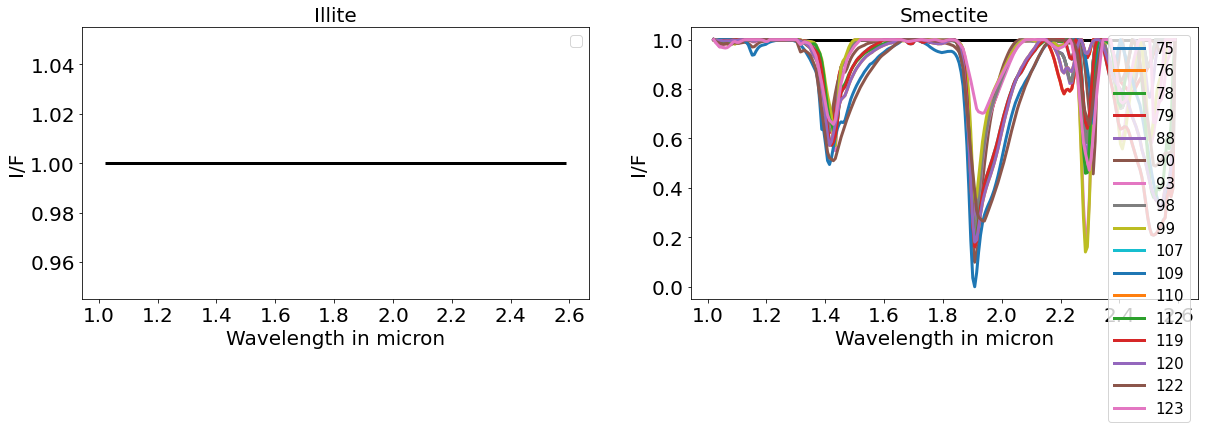

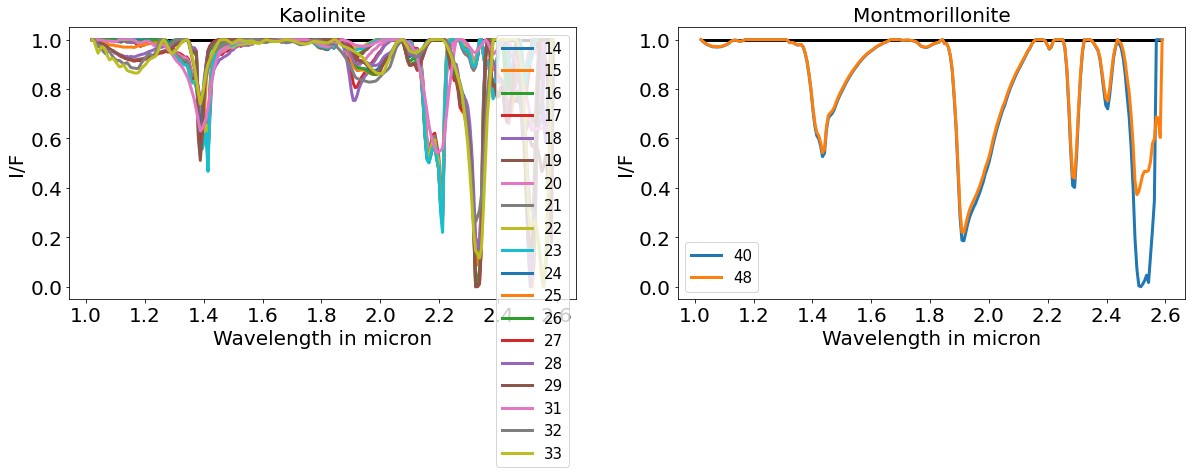

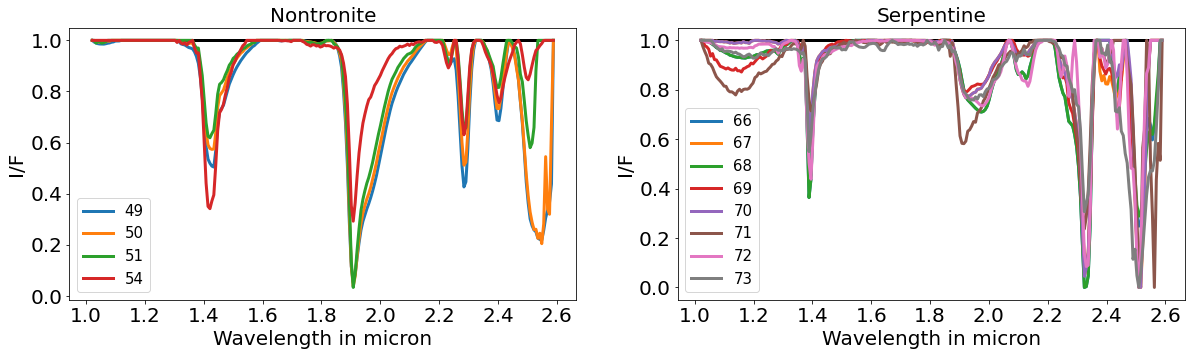

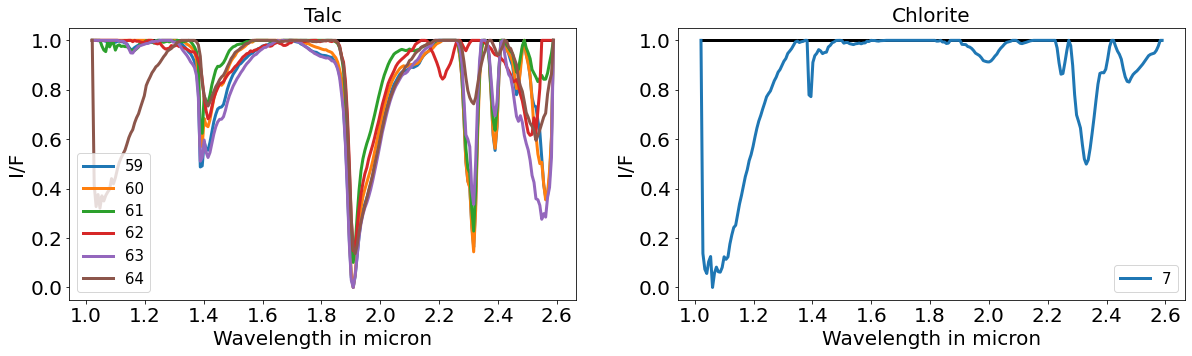

In [51]:
#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    
    #create plots
    if i%2==0:
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
    else:
        plt.subplot(1,2,2) 
    #add title
    plt.title(currentTypeName,fontsize=20)
    #change size of ticks
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #add axis labels
    plt.ylabel("I/F",fontsize=20)
    plt.xlabel("Wavelength in micron",fontsize=20)
    #add horizontal line for y=1
    plt.hlines(y=1,xmin=wavelengthList[0],xmax=wavelengthList[-1],lw=3,color="black")

    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures):
            if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #plot the spectra
            plt.plot(wavelengthList,crSpectra,lw=3,label=str(j))
            print(f"{j}--{(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])}--{bandCentres[firstCO3FeatureIndex]}--{bandCentres[firstCO3FeatureIndex+1]}")
    plt.legend(loc="best",fontsize=15)
        
        

In [52]:

#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
mineralSampleList=[]
#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    #print name of phyllosilicate type
    print(currentTypeName)
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures):
            if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            print(f"{j}--{(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])}--{bandCentres[firstCO3FeatureIndex]}--{bandCentres[firstCO3FeatureIndex+1]}")
            ibg=(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])
            bandCentre23=bandCentres[firstCO3FeatureIndex]
            bandCentre25=bandCentres[firstCO3FeatureIndex+1]
            currentMineralSample=MineralSample(currentTypeName,j,ibg,bandCentre23,bandCentre25)
            mineralSampleList.append(currentMineralSample)
    #plt.legend(loc="best",fontsize=15)
        
        

Illite
Smectite
75--0.11639600000000083--2.289998000000001--2.406394000000002
76--0.1495919999999895--2.2913200000000007--2.44091199999999
78--0.11639600000000083--2.289998000000001--2.406394000000002
79--0.1495919999999895--2.2913200000000007--2.44091199999999


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


88--0.11516599999999277--2.289998000000001--2.405163999999994
90--0.07943999999999463--2.311150000000002--2.3905899999999964
93--0.12045799999999351--2.287344000000002--2.4078019999999953
98--0.11639600000000083--2.289998000000001--2.406394000000002
99--0.12169400000000019--2.287344000000002--2.409038000000002
107--0.2236859999999874--2.2900459999999967--2.513731999999984
109--0.07673599999999992--2.3098280000000013--2.3865640000000012
110--0.25285999999998054--2.2886760000000006--2.541535999999981
112--0.11508399999999996--2.287344000000002--2.402428000000002
119--0.2236859999999874--2.2900459999999967--2.513731999999984
120--0.25285999999998054--2.2886760000000006--2.541535999999981
122--0.10849399999999942--2.297920000000002--2.4064140000000016
123--0.10987199999999442--2.297920000000002--2.4077919999999966
Kaolinite
14--0.06483799999999951--2.3190820000000016--2.383920000000001
15--0.06615999999999955--2.3177600000000016--2.383920000000001
16--0.06615999999999955--2.317760000000001

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


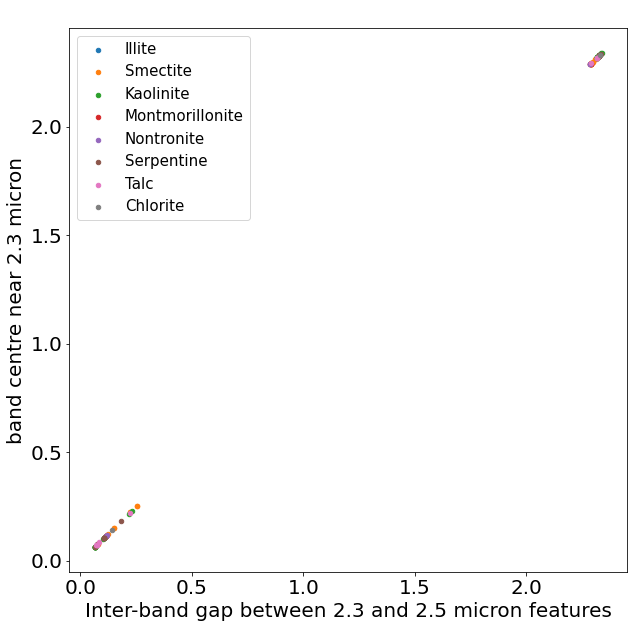

In [53]:
#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(10,10))
#add title
plt.title("  ",fontsize=20)
#change size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#add axis labels
plt.ylabel("band centre near 2.3 micron",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)

#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    #create arrays to hold incides 2.3 band centre and IBG
    bandcentre23=ibg=[]
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures-1):
            if k<noOfFeatures and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            bandcentre23.append(bandCentres[firstCO3FeatureIndex])
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
    plt.scatter(ibg,bandcentre23,label=currentTypeName,s=20)
plt.legend(loc="best",fontsize=15)
        
        

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


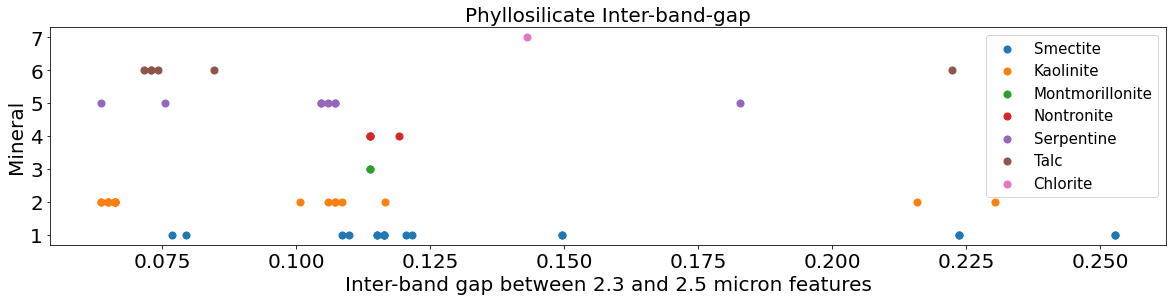

In [54]:
#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(20,4))
#add title
plt.title("Phyllosilicate Inter-band-gap",fontsize=20)
#change size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)

#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures-1):
            if k<noOfFeatures and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(i)
    if len(ibg)>0:
        plt.scatter(ibg,names,label=currentTypeName,s=50)
plt.legend(loc="best",fontsize=15)
        
        

In [ ]:
#get spectra and sample names in the library
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(20,4))
#add title
plt.title("Carbonate Inter-band-gap",fontsize=20)
#change size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)


#process each carbonate type
for i in range(len(carbonateTypeIndices)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of carbonate type
    currentTypeName=carbonateTypeNames[i]
    #get indices of carbonate type
    currentTypeIndices=carbonateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #check if spectra is to be skipped
        if j in carbonateIndicestoSkip:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures-1):
            if k<noOfFeatures and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(i)
    if len(ibg)>0:
        plt.scatter(ibg,names,label=currentTypeName,s=50)
plt.legend(loc="best",fontsize=15)
        
        

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


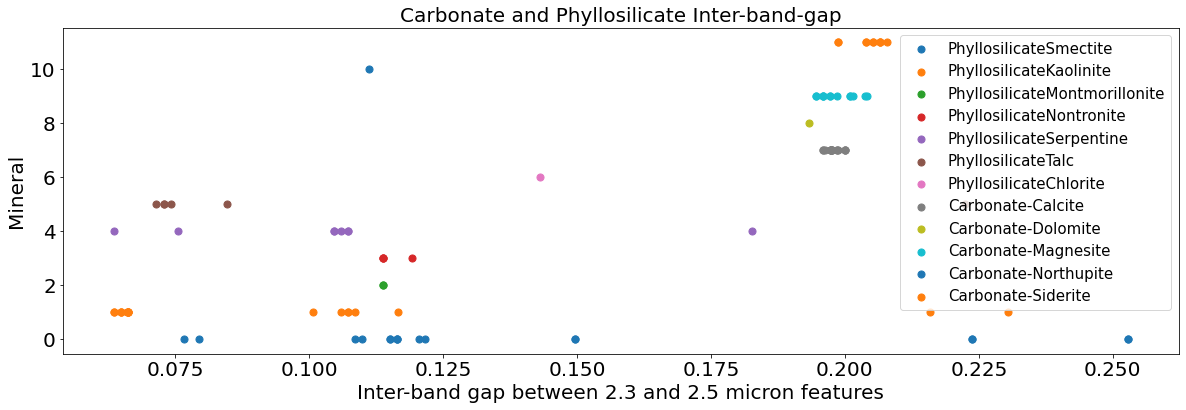

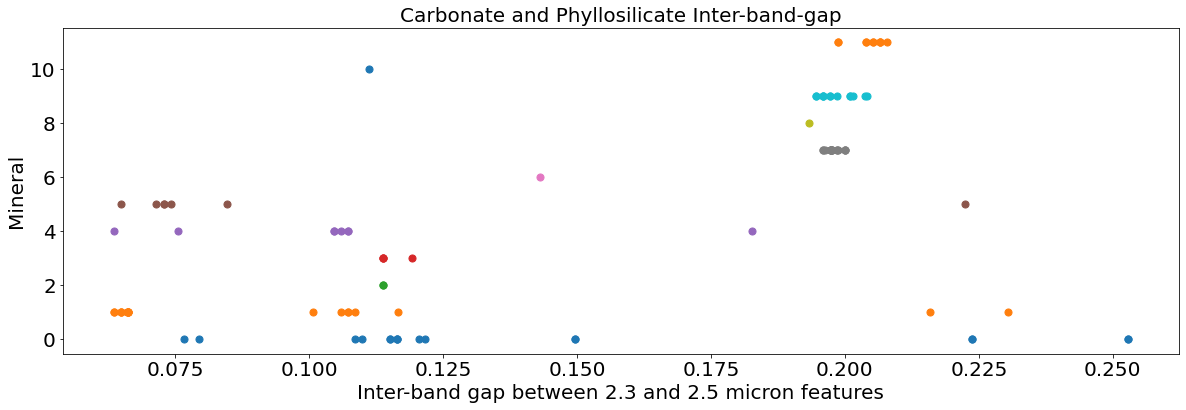

In [55]:
#create an array to hold the ibg
allInterBandGaps=[]
#create an array to hold y axis
allYAxis=[]
#create array to hold mineral names
mineralNamesPlotted=[]
#create array to hold makers
markersPlotted=[]

#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(20,6))
#add title
plt.title("Carbonate and Phyllosilicate Inter-band-gap",fontsize=20)
#change size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)
spectraCounter=0
#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        if j in ignorePhyllosilicateIndices:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures):
            if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(spectraCounter)
    if len(ibg)>0:
        plt.scatter(ibg,names,label="Phyllosilicate"+currentTypeName,s=50)
        spectraCounter=spectraCounter+1
#get spectra and sample names in the library
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#process each carbonate type
for i in range(len(carbonateTypeIndices)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of carbonate type
    currentTypeName=carbonateTypeNames[i]
    #get indices of carbonate type
    currentTypeIndices=carbonateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        #check if spectra is to be skipped
        if j in carbonateIndicestoSkip:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures-1):
            if k<noOfFeatures and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(spectraCounter)
    if len(ibg)>0:
        plt.scatter(ibg,names,label="Carbonate-"+currentTypeName,s=50)
        spectraCounter=spectraCounter+1
plt.legend(loc="best",fontsize=15)

#get spectra and sample names in the library
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(20,6))
#add title
plt.title("Carbonate and Phyllosilicate Inter-band-gap",fontsize=20)
#change size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)
spectraCounter=0
#process each pyllosilicate type
for i in range(len(pyhllosilicateTypeNames)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of phyllosilicate type
    currentTypeName=pyhllosilicateTypeNames[i]
    #get indices of phyllosilicate type
    currentTypeIndices=phyllosilicateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures):
            if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(spectraCounter)
    if len(ibg)>0:
        plt.scatter(ibg,names,label="Phyllosilicate-"+currentTypeName+"-"+str(j),s=50)
        spectraCounter=spectraCounter+1
        #add all ibg to complete list
        allInterBandGaps.extend(ibg)
        #add y-axis values to complete list
        allYAxis.extend(names)
        #create array to hold mineral names
        mineralNamesPlotted.append(currentTypeName)
        #create array to hold makers
        markersPlotted.append(spectraCounter)    
#get spectra and sample names in the library
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#process each carbonate type
for i in range(len(carbonateTypeIndices)):
    #create arrays to hold incides 2.3 band centre and names
    ibg=[]
    names=[]
    #get name of carbonate type
    currentTypeName=carbonateTypeNames[i]
    #get indices of carbonate type
    currentTypeIndices=carbonateTypeIndices[i]
    #iterate over all spectras
    for j in range(currentTypeIndices[0],currentTypeIndices[1]):
        #check if spectra is to be skipped
        if j in carbonateIndicestoSkip:
            continue
        #get current spectra
        currentSpectra=librarySpectras[j,:]
        #normalize spectra
        normalizedSpectra=normalizeSpectra(currentSpectra)
        #remove continuum
        crSpectra=plotHull(normalizedSpectra)
        #extract features
        features,wavelengths=getAbsorptionFeatures(crSpectra)
        #get spectral parameters
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        
        #variable to store index of 2.3 feature
        firstCO3FeatureIndex=-1
        #get no of features
        noOfFeatures=len(fwhms)
        #iterate over all features
        for k in range(noOfFeatures-1):
            if k<noOfFeatures and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
                firstCO3FeatureIndex=k
        #check if CO3 feature present
        if firstCO3FeatureIndex>=0:
            #append 2.3 band centre and ibg 
            ibg.append(abs(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex]))
            names.append(spectraCounter)
    if len(ibg)>0:
        plt.scatter(ibg,names,label="Carbonate-"+currentTypeName,s=50)
        spectraCounter=spectraCounter+1
        #add all ibg to complete list
        allInterBandGaps.extend(ibg)
        #add y-axis values to complete list
        allYAxis.extend(names)
        #create array to hold mineral names
        mineralNamesPlotted.append(currentTypeName)
        #create array to hold makers
        markersPlotted.append(spectraCounter)   
#plt.legend(loc="best",fontsize=15)

In [ ]:
#create figure
plt.figure(figsize=(20,8))
#add title
plt.title("Carbonate and Phyllosilicate Inter-band-gap",fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)
#add ticks on x-axis
plt.xticks(np.round(np.arange(min(allInterBandGaps),max(allInterBandGaps)+0.03,0.02),2),fontsize=20)
#add ticks on y-axis
plt.yticks(np.array(markersPlotted)-1,labels=mineralNamesPlotted,fontsize=20)
#calculate density of points
xy=np.vstack([allInterBandGaps,allYAxis])
density=stats.gaussian_kde(xy)(xy)
#plot scatter plot with density color
plt.scatter(allInterBandGaps,allYAxis,c=density,s=50,cmap='gist_rainbow')
#calculate total number of points
totalPoints=len(allInterBandGaps)
#calculate maximum point density
maxPoints=round(max(density)*totalPoints,0)
#calculate minimum point density
minPoints=round(min(density)*totalPoints,0)
#calculate total point density



#get labels
cBarLabels=np.round(np.arange(minPoints,maxPoints,(maxPoints-minPoints)/9)).astype(int)
#create colorbar
cBar=plt.colorbar(ticks=np.arange(0.2,2.0,0.2))
cBar.ax.set_yticklabels(cBarLabels)
cBar.ax.tick_params(labelsize=20)
cBar.set_label('Frequency',rotation=270,fontsize=20)
#plot horizontal lines for better visibility
for i in range(len(mineralNamesPlotted)):
    #plt.hlines(y=i,xmin=min(allInterBandGaps),xmax=max(allInterBandGaps),linestyle='dotted',color="gray")
    plt.hlines(y=i,xmin=0.06,xmax=0.26,linestyle='dotted',color="gray")
#add vertical lines to mark carbonate range
maxPointValues=11.2
plt.vlines(x=0.19,ymin=-0.2,ymax=maxPointValues,color='black',linestyle='dashed',lw=3)
plt.text(x=0.179,y=maxPointValues,s="0.19",fontsize=20)
plt.vlines(x=0.21,ymin=-0.2,ymax=maxPointValues,color='black',linestyle='dashed',lw=3)
plt.text(x=0.211,y=maxPointValues,s="0.21",fontsize=20)
plt.vlines(x=0.20,ymin=-0.2,ymax=maxPointValues,color='red',linestyle='dashed',lw=2)
plt.text(x=0.195,y=maxPointValues,s="0.20",fontsize=20,color='red')


Text(0.195, 11.2, '0.20')

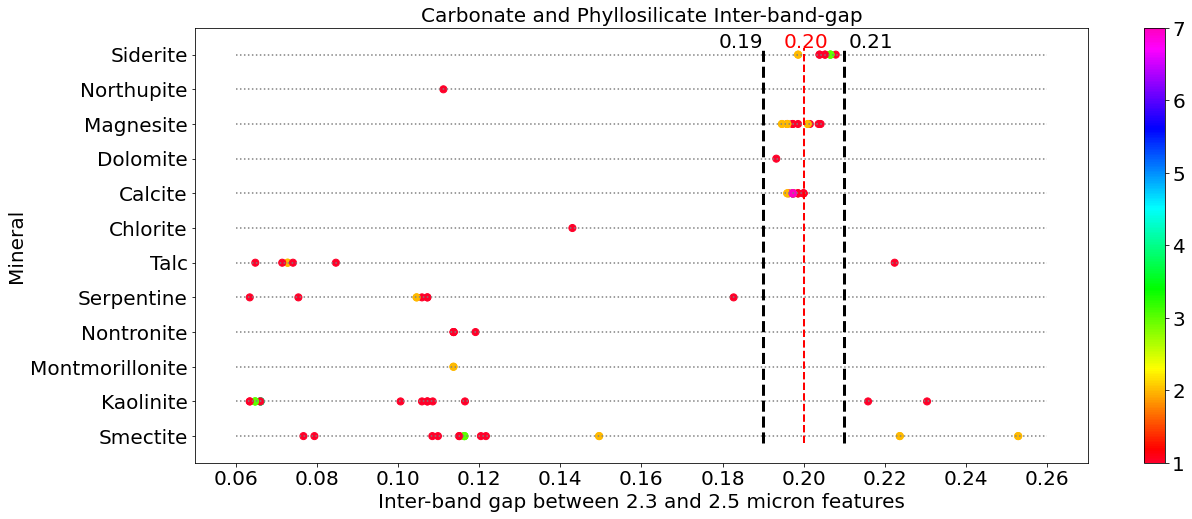

In [56]:
#create figure
plt.figure(figsize=(20,8))
#add title
plt.title("Carbonate and Phyllosilicate Inter-band-gap",fontsize=20)
#add axis labels
plt.ylabel("Mineral",fontsize=20)
plt.xlabel("Inter-band gap between 2.3 and 2.5 micron features",fontsize=20)
#add ticks on x-axis
plt.xticks(np.round(np.arange(min(allInterBandGaps),max(allInterBandGaps)+0.03,0.02),2),fontsize=20)
#add ticks on y-axis
plt.yticks(np.array(markersPlotted)-1,labels=mineralNamesPlotted,fontsize=20)
#calculate density of points
xy=list(zip(allInterBandGaps,allYAxis))
count=Counter(xy)
density=[count[(allInterBandGaps[i],allYAxis[i])] for  i,_ in enumerate(allInterBandGaps)]
#plot scatter plot with density color
plt.scatter(allInterBandGaps,allYAxis,c=density,s=50,cmap='gist_rainbow')
#calculate total number of points
totalPoints=len(density)
#calculate maximum point density
maxPoints=round(max(density),0)
#calculate minimum point density
minPoints=round(min(density),0)
#get labels
cBarLabels=np.round(np.arange(1,8,1)).astype(int)
#create colorbar
cBar=plt.colorbar(ticks=cBarLabels)
cBar.ax.set_yticklabels(cBarLabels)
cBar.ax.tick_params(labelsize=20)
#cBar.set_label('Frequency',rotation=270,fontsize=20)
#plot horizontal lines for better visibility
for i in range(len(mineralNamesPlotted)):
    #plt.hlines(y=i,xmin=min(allInterBandGaps),xmax=max(allInterBandGaps),linestyle='dotted',color="gray")
    plt.hlines(y=i,xmin=0.06,xmax=0.26,linestyle='dotted',color="gray")
#add vertical lines to mark carbonate range
maxPointValues=11.2
plt.vlines(x=0.19,ymin=-0.2,ymax=maxPointValues,color='black',linestyle='dashed',lw=3)
plt.text(x=0.179,y=maxPointValues,s="0.19",fontsize=20)
plt.vlines(x=0.21,ymin=-0.2,ymax=maxPointValues,color='black',linestyle='dashed',lw=3)
plt.text(x=0.211,y=maxPointValues,s="0.21",fontsize=20)
plt.vlines(x=0.20,ymin=-0.2,ymax=maxPointValues,color='red',linestyle='dashed',lw=2)
plt.text(x=0.195,y=maxPointValues,s="0.20",fontsize=20,color='red')


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

76
77


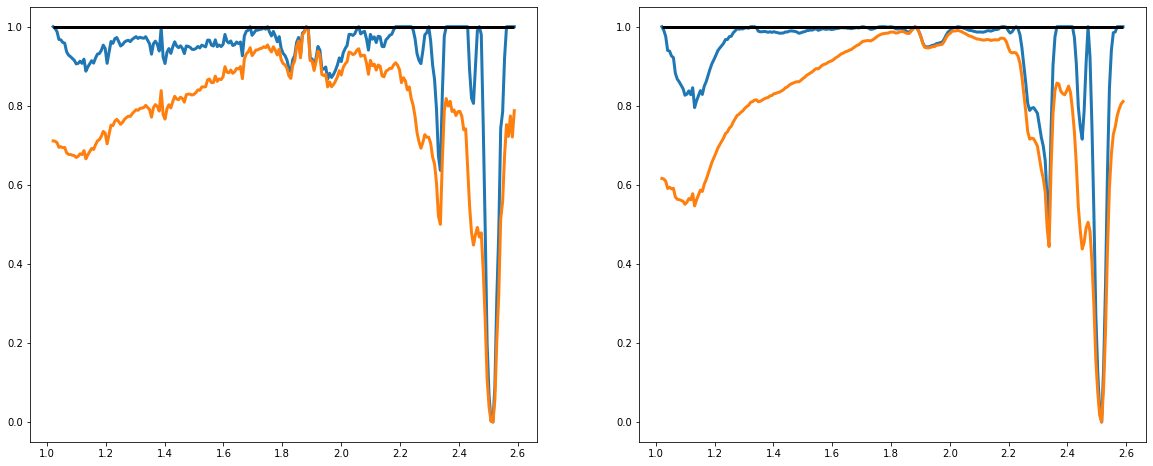

In [57]:
#get spectra and sample names in the library
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
#create figure
plt.figure(figsize=(20,8))
for i in northupiteIndexRange:
    plt.subplot(1,2,i-northupiteIndexRange[0]+1)
    plt.plot(wavelengthList,plotHull(normalizeSpectra(librarySpectras[i,:])),lw=3)
    plt.plot(wavelengthList,normalizeSpectra(librarySpectras[i,:]),lw=3)
    plt.hlines(y=1.0,xmin=wavelengthList[0],xmax=wavelengthList[-1],color='black',lw=3)
    print(i)

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

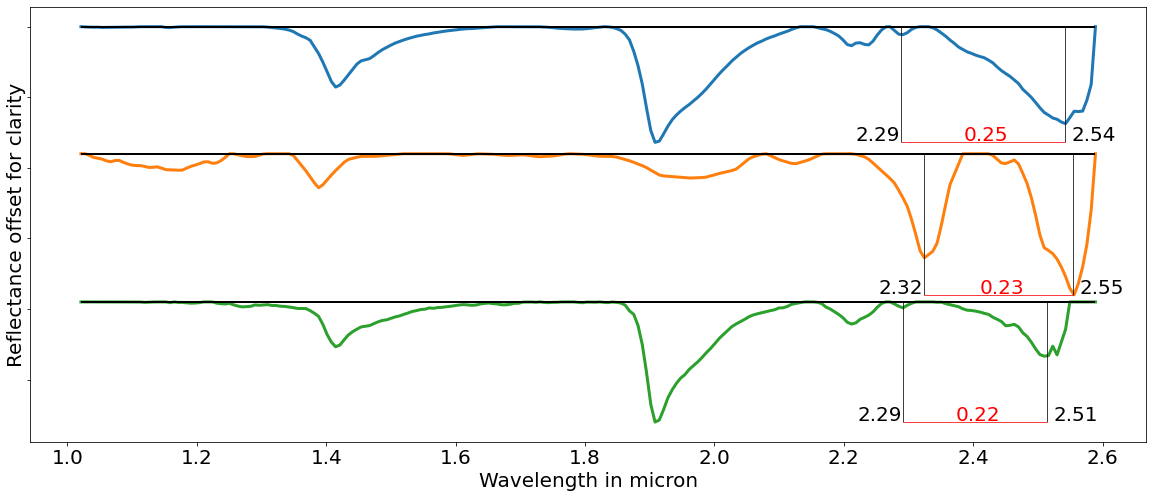

In [58]:
plt.figure(figsize=(20,8))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offsets=[0,0.9,1.95]
offsetCounter=0
for t in range(len(mineralSampleList)):
            
    i=mineralSampleList[t]
    #calculate density of points
    currentSampleIndex=i.sampleIndex
    if not(currentSampleIndex in [110,32,62]):
        continue
    
    currentMineralName=i.mineralName
    currentIBG=i.interBandGap
    currentBC23=i.bandCentre23
    currentBC25=i.bandCentre25
    if currentIBG>0.19:    
        plt.plot(wavelengthList,plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offsets[offsetCounter],label=names[currentSampleIndex]+" "+str(currentSampleIndex),lw=3)
        
        minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offsets[offsetCounter])
        maximumReflectance=1-offsets[offsetCounter]
        
        plt.hlines(y=1-offsets[offsetCounter],
                   xmin=wavelengthList[0],
                   xmax=wavelengthList[-1],
                   lw=2,
                   color='black')
        plt.vlines(x=currentBC23,
                   ymax=maximumReflectance,
                   ymin=minimumReflectance,
                   lw=0.75,
                   color='black')
        plt.vlines(x=currentBC25,
                   ymax=maximumReflectance,
                   ymin=minimumReflectance,
                   lw=0.75,
                   color='black')
        plt.hlines(y=minimumReflectance,
                   xmin=currentBC23,
                   xmax=currentBC25,
                   lw=0.75,
                   color='red')
        #plot inter-band gap
        plt.text(x=currentBC23+(currentBC25-currentBC23)/2-0.03,
                 y=minimumReflectance+0.01,
                 s=str(round(currentIBG,2)),
                 fontsize=20,
                 color='red')
        #plot 2.3 micron band-centre
        plt.text(x=currentBC23-0.07,
                 y=minimumReflectance+0.01,
                 s=str(round(currentBC23,2)),
                 fontsize=20,
                 color='black')
        #plot 2.5 micron band-centre
        plt.text(x=currentBC25+0.01,
                 y=minimumReflectance+0.01,
                 s=str(round(currentBC25,2)),
                 fontsize=20,
                 color='black')
        offsetCounter=offsetCounter+1
        

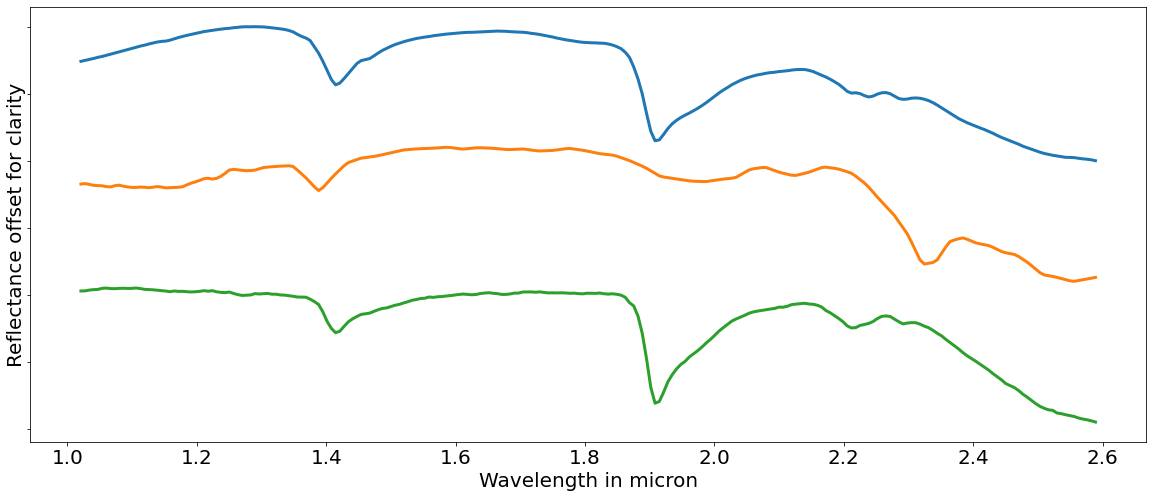

In [59]:
plt.figure(figsize=(20,8))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offsets=[0,0.9,1.95]
offsetCounter=0
for t in range(len(mineralSampleList)):
            
    i=mineralSampleList[t]
    #calculate density of points
    currentSampleIndex=i.sampleIndex
    if not(currentSampleIndex in [110,32,62]):
        continue
    
    currentMineralName=i.mineralName
    currentIBG=i.interBandGap
    currentBC23=i.bandCentre23
    currentBC25=i.bandCentre25
    if currentIBG>0.19:    
        plt.plot(wavelengthList,normalizeSpectra(librarySpectras[currentSampleIndex,:])-offsets[offsetCounter],label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],lw=3)
        
        offsetCounter=offsetCounter+1

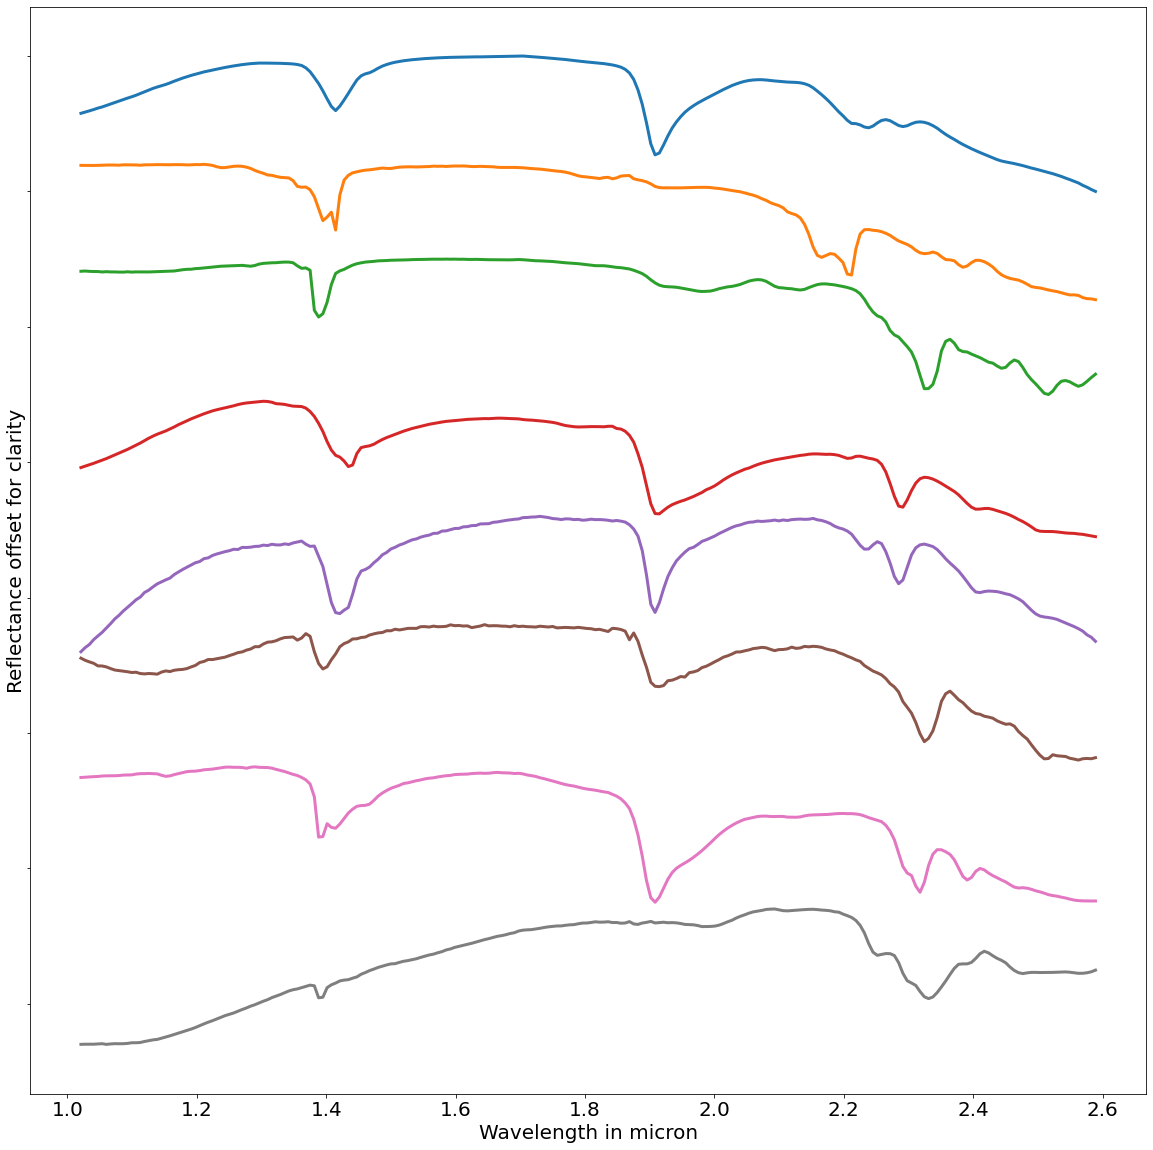

In [60]:
plt.figure(figsize=(20,20))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offset=[0,0.8,1.5,2.55,3.4,4.2,5.25,6.3]
offsetCounter=0
for t in range(len(mineralSampleList)):
            
    i=mineralSampleList[t]
    #calculate density of points
    currentSampleIndex=i.sampleIndex
    if not(currentSampleIndex in [59,71,14,54,48,25,76,7]):
        continue
    currentMineralName=i.mineralName
    currentIBG=i.interBandGap
    currentBC23=i.bandCentre23
    currentBC25=i.bandCentre25
    if currentIBG<0.19:    
        plt.plot(wavelengthList,normalizeSpectra(librarySpectras[currentSampleIndex,:])-offset[offsetCounter],label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],lw=3)
        offsetCounter=offsetCounter+1
    #plt.legend(loc="best",fontsize=20)

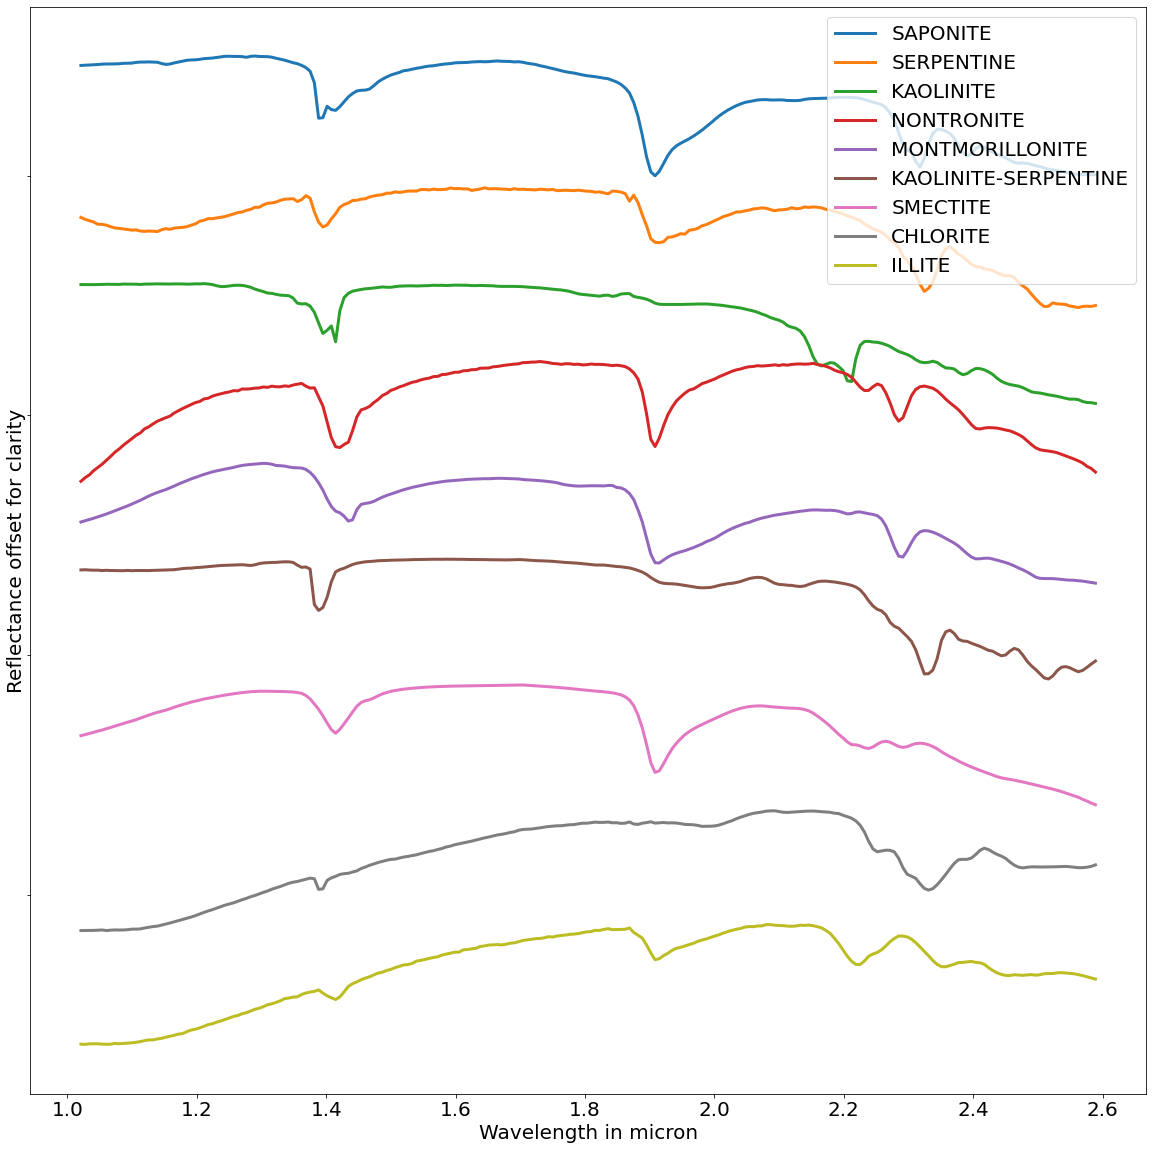

In [61]:
plt.figure(figsize=(20,20))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offset=[0,1.1,1.9,2.55,3.4,4.2,5.25,6.3,7.25]
offsetCounter=0
for i in [59,71,14,54,48,25,76,7,11]:
    #calculate density of points
    currentSampleIndex=i
    if not(currentSampleIndex in [59,71,14,54,48,25,76,7,11]):
        continue   
    plt.plot(wavelengthList,normalizeSpectra(librarySpectras[currentSampleIndex,:])-offset[offsetCounter],label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],lw=3)
    offsetCounter=offsetCounter+1
plt.legend(loc="best",fontsize=20)

[1.0275499999999995, 1.909567999999998, 2.2212540000000027, 2.350830000000002, 2.451483999999996]


C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

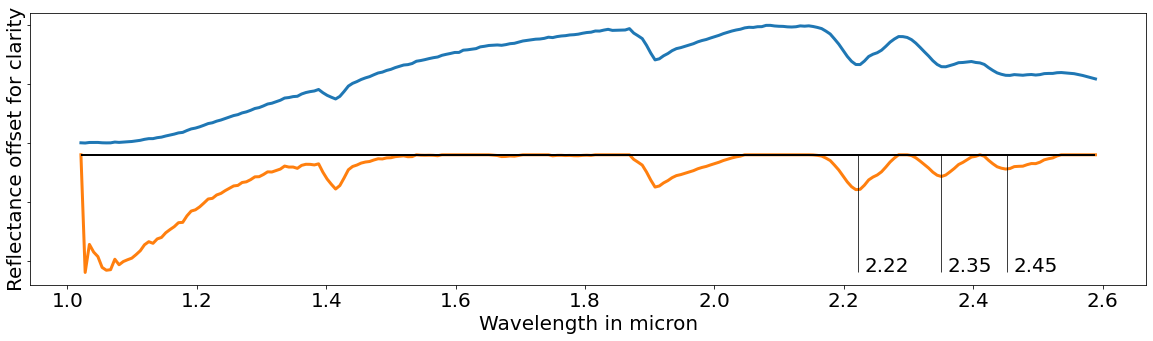

In [62]:
plt.figure(figsize=(20,5))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offset=[0,1.1,1.9,2.55,3.4,4.2,5.25,6.3,7.25]
offsetCounter=0
for i in [11]:
    #calculate density of points
    currentSampleIndex=i
    if not(currentSampleIndex in [59,71,14,54,48,25,76,7,11]):
        continue   
    plt.plot(wavelengthList,
             normalizeSpectra(librarySpectras[currentSampleIndex,:])-offset[offsetCounter],
             label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],
             lw=3)
    offsetCounter=offsetCounter+1
    plt.plot(wavelengthList,
             plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter],
             label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],
             lw=3)
    #normalize spectra
    normalizedSpectra=normalizeSpectra(librarySpectras[currentSampleIndex,:])
    #remove continuum
    crSpectra=plotHull(normalizedSpectra)
    #extract features
    features,wavelengths=getAbsorptionFeatures(crSpectra)
    #get spectral parameters
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
    minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-1.1)
    maximumReflectance=1-1.1
    
    print(bandCentres)
    
    plt.hlines(y=1-1.1,
               xmin=wavelengthList[0],
               xmax=wavelengthList[-1],
               lw=2,
               color='black')
    plt.vlines(x=bandCentres[-1],
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.vlines(x=bandCentres[-2],
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.vlines(x=bandCentres[-3],
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.text(x=bandCentres[-1]+0.01,
             y=minimumReflectance+0.01,
             s=str(round(bandCentres[-1],2)),
             fontsize=20,
             color='black')
    plt.text(x=bandCentres[-2]+0.01,
             y=minimumReflectance+0.01,
             s=str(round(bandCentres[-2],2)),
             fontsize=20,
             color='black')
    plt.text(x=bandCentres[-3]+0.01,
             y=minimumReflectance+0.01,
             s=str(round(bandCentres[-3],2)),
             fontsize=20,
             color='black')

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

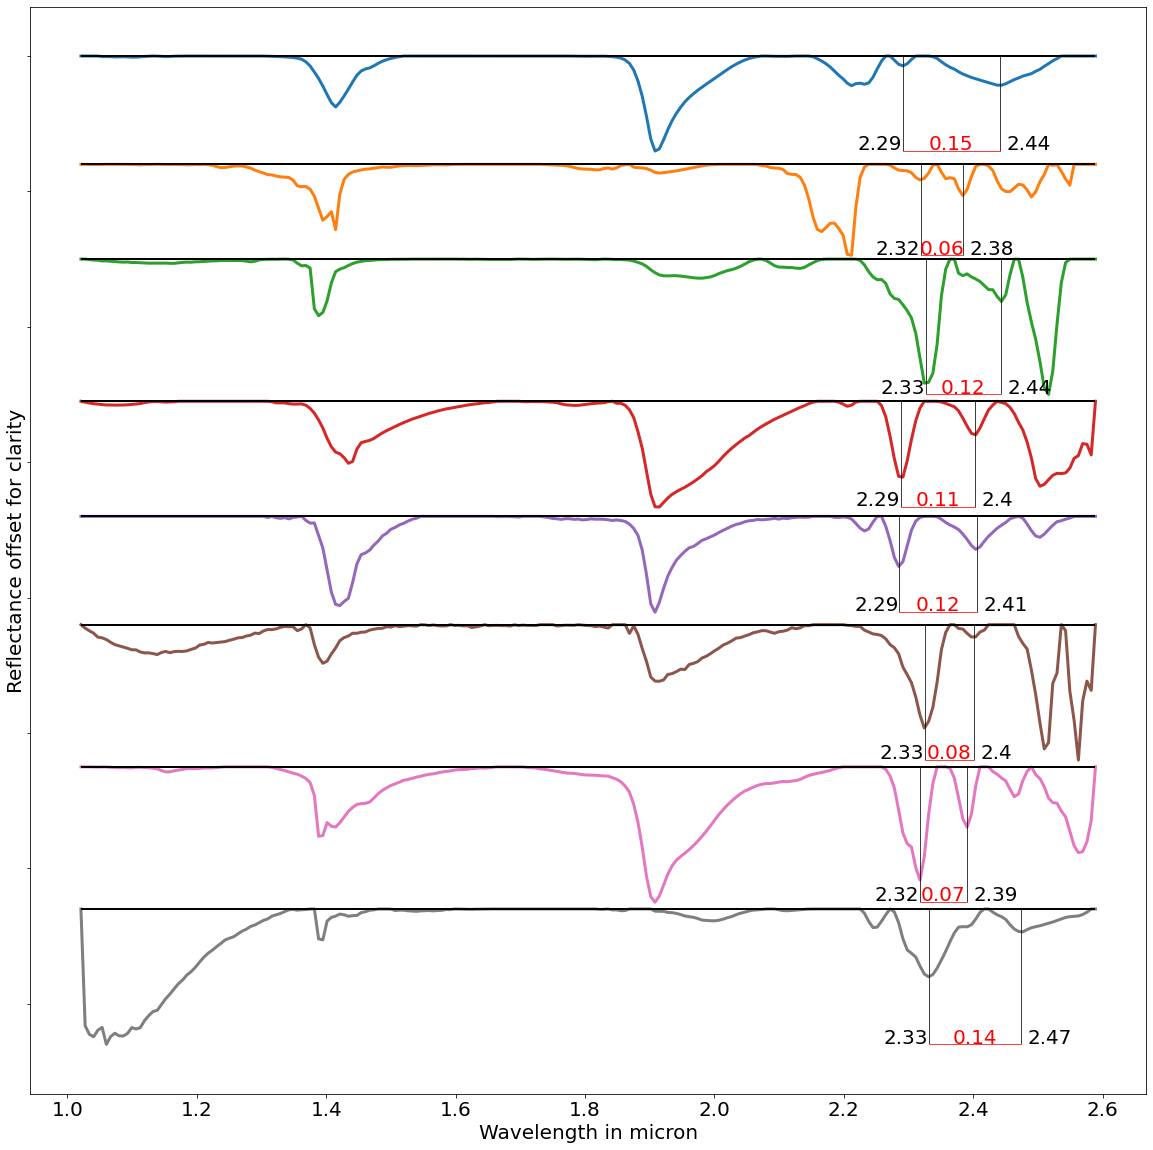

In [63]:
plt.figure(figsize=(20,20))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)


index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)

#create a counter to be used to adjust multiplication for offset 
offset=[0,0.8,1.5,2.55,3.4,4.2,5.25,6.3]
offsetCounter=0
for t in range(len(mineralSampleList)):
            
    i=mineralSampleList[t]
    #calculate density of points
    currentSampleIndex=i.sampleIndex
    if not(currentSampleIndex in [59,71,14,54,48,25,76,7]):
        continue
    currentMineralName=i.mineralName
    currentIBG=i.interBandGap
    currentBC23=i.bandCentre23
    currentBC25=i.bandCentre25
    if currentIBG<0.19:    
        plt.plot(wavelengthList,plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter],label=names[currentSampleIndex][:names[currentSampleIndex].index(' ')],lw=3)
        minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter])
        maximumReflectance=1-offset[offsetCounter]
        
        plt.hlines(y=1-offset[offsetCounter],
                   xmin=wavelengthList[0],
                   xmax=wavelengthList[-1],
                   lw=2,
                   color='black')
        plt.vlines(x=currentBC23,
                   ymax=maximumReflectance,
                   ymin=minimumReflectance,
                   lw=0.75,
                   color='black')
        plt.vlines(x=currentBC25,
                   ymax=maximumReflectance,
                   ymin=minimumReflectance,
                   lw=0.75,
                   color='black')
        plt.hlines(y=minimumReflectance,
                   xmin=currentBC23,
                   xmax=currentBC25,
                   lw=0.75,
                   color='red')
        #plot inter-band gap
        plt.text(x=currentBC23+(currentBC25-currentBC23)/2-0.035,
                 y=minimumReflectance+0.01,
                 s=str(round(currentIBG,2)),
                 fontsize=20,
                 color='red')
        #plot 2.3 micron band-centre
        plt.text(x=currentBC23-0.07,
                 y=minimumReflectance+0.01,
                 s=str(round(currentBC23,2)),
                 fontsize=20,
                 color='black')
        #plot 2.5 micron band-centre
        plt.text(x=currentBC25+0.01,
                 y=minimumReflectance+0.01,
                 s=str(round(currentBC25,2)),
                 fontsize=20,
                 color='black')
        offsetCounter=offsetCounter+1
    #plt.legend(loc="best",fontsize=20)

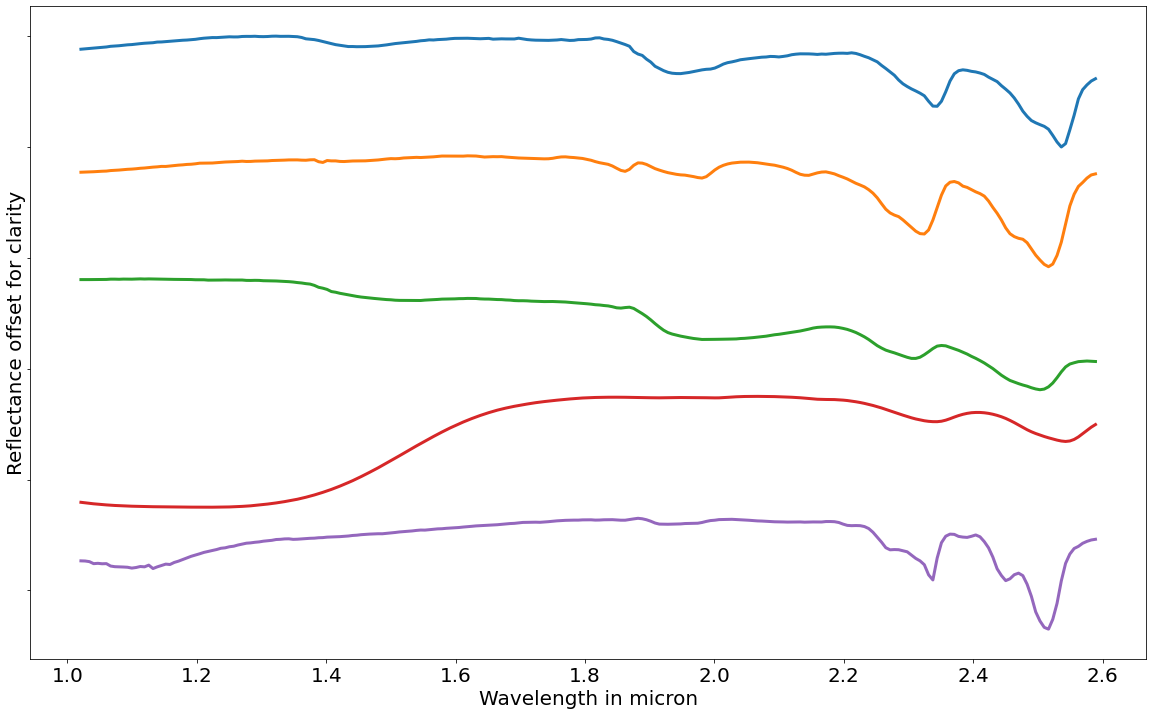

In [64]:
plt.figure(figsize=(20,12))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#iterate over all samples of current type
    

#get all samples
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
# set indices for carbonates to plot
carbonateIndices=[15,43,61,85,77]
#create a counter to be used to adjust multiplication for offset 
offset=[0,1.08,2.19,3.25,4.35]
offsetCounter=0
#iterate over all carbonate types
for i in carbonateIndices:
    currentSpectra=librarySpectras[i,:]
    plt.plot(wavelengthList,
             normalizeSpectra(currentSpectra)-offset[offsetCounter],
             label=str(names[i][:names[i].index(' ')]),
             lw=3)
    offsetCounter=offsetCounter+1
#plt.legend(loc="best",fontsize=20)

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

87--0.1973199999999835--2.340224000000004--2.5375439999999876
87--0.19457399999997804--2.321786000000009--2.516359999999987
87--0.19860199999998285--2.305852000000004--2.5044539999999866
87--0.20657799999998483--2.3336140000000047--2.5401919999999896
87--0.11390199999999329--2.336258000000004--2.4501599999999972


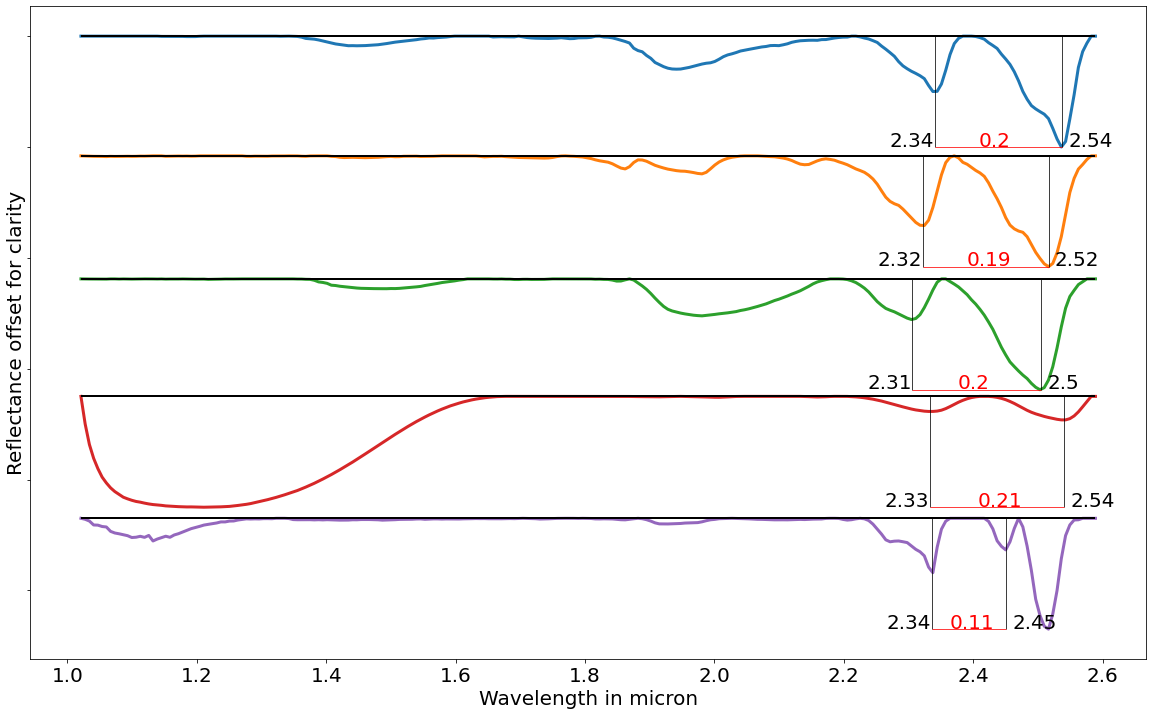

In [65]:
plt.figure(figsize=(20,12))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#iterate over all samples of current type
    

#get all samples
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
# set indices for carbonates to plot
carbonateIndices=[15,43,61,85,77]
#create a counter to be used to adjust multiplication for offset 
offset=[0,1.08,2.19,3.25,4.35]
offsetCounter=0
#iterate over all carbonate types
for i in carbonateIndices:
    currentSpectra=librarySpectras[i,:]
    #normalize spectra
    normalizedSpectra=normalizeSpectra(currentSpectra)
    #remove continuum
    crSpectra=plotHull(normalizedSpectra)
    #extract features
    features,wavelengths=getAbsorptionFeatures(crSpectra)
    #get spectral parameters
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)

    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    #iterate over all features
    for k in range(noOfFeatures):
        if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
            firstCO3FeatureIndex=k
    #check if CO3 feature present
    if firstCO3FeatureIndex>=0:
        print(f"{j}--{(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])}--{bandCentres[firstCO3FeatureIndex]}--{bandCentres[firstCO3FeatureIndex+1]}")
        ibg=(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])
        currentBC23=bandCentres[firstCO3FeatureIndex]
        currentBC25=bandCentres[firstCO3FeatureIndex+1]
        currentIBG=currentBC25-currentBC23
        minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter])
        maximumReflectance=1-offset[offsetCounter]
        
    plt.plot(wavelengthList,
             plotHull(normalizeSpectra(currentSpectra))-offset[offsetCounter],
             label=str(names[i][:names[i].index(' ')]),
             lw=3)
    plt.hlines(y=1-offset[offsetCounter],
               xmin=wavelengthList[0],
               xmax=wavelengthList[-1],
               lw=2,
               color='black')
    plt.vlines(x=currentBC23,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.vlines(x=currentBC25,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.hlines(y=minimumReflectance,
               xmin=currentBC23,
               xmax=currentBC25,
               lw=0.75,
               color='red')
    #plot inter-band gap
    plt.text(x=currentBC23+(currentBC25-currentBC23)/2-0.03,
             y=minimumReflectance+0.01,
             s=str(round(currentIBG,2)),
             fontsize=20,
             color='red')
    #plot 2.3 micron band-centre
    plt.text(x=currentBC23-0.07,
             y=minimumReflectance+0.01,
             s=str(round(currentBC23,2)),
             fontsize=20,
             color='black')
    #plot 2.5 micron band-centre
    plt.text(x=currentBC25+0.01,
             y=minimumReflectance+0.01,
             s=str(round(currentBC25,2)),
             fontsize=20,
             color='black')
    offsetCounter=offsetCounter+1

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

87--0.1973199999999835--2.340224000000004--2.5375439999999876
87--0.19457399999997804--2.321786000000009--2.516359999999987
87--0.19860199999998285--2.305852000000004--2.5044539999999866
87--0.20657799999998483--2.3336140000000047--2.5401919999999896
87--0.11390199999999329--2.336258000000004--2.4501599999999972


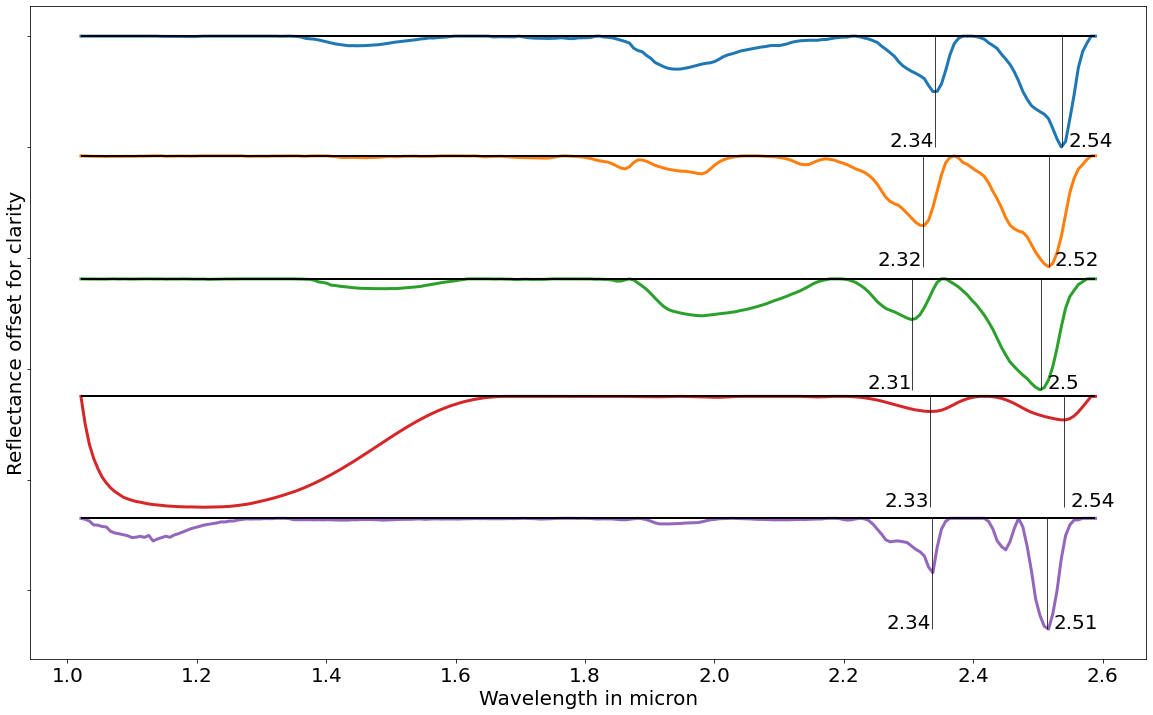

In [66]:
plt.figure(figsize=(20,12))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#iterate over all samples of current type
    

#get all samples
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
# set indices for carbonates to plot
carbonateIndices=[15,43,61,85,77]
#create a counter to be used to adjust multiplication for offset 
offset=[0,1.08,2.19,3.25,4.35]
offsetCounter=0
#iterate over all carbonate types
for i in carbonateIndices:
    currentSpectra=librarySpectras[i,:]
    #normalize spectra
    normalizedSpectra=normalizeSpectra(currentSpectra)
    #remove continuum
    crSpectra=plotHull(normalizedSpectra)
    #extract features
    features,wavelengths=getAbsorptionFeatures(crSpectra)
    #get spectral parameters
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)

    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    #iterate over all features
    for k in range(noOfFeatures):
        if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
            firstCO3FeatureIndex=k
    #check if CO3 feature present
    if firstCO3FeatureIndex>=0:
        print(f"{j}--{(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])}--{bandCentres[firstCO3FeatureIndex]}--{bandCentres[firstCO3FeatureIndex+1]}")
        ibg=(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])
        currentBC23=bandCentres[firstCO3FeatureIndex]
        currentBC25=bandCentres[-1]
        currentIBG=currentBC25-currentBC23
        minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter])
        maximumReflectance=1-offset[offsetCounter]
        
    plt.plot(wavelengthList,
             plotHull(normalizeSpectra(currentSpectra))-offset[offsetCounter],
             label=str(names[i][:names[i].index(' ')]),
             lw=3)
    plt.hlines(y=1-offset[offsetCounter],
               xmin=wavelengthList[0],
               xmax=wavelengthList[-1],
               lw=2,
               color='black')
    plt.vlines(x=currentBC23,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.vlines(x=currentBC25,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    '''
    plt.hlines(y=minimumReflectance,
               xmin=currentBC23,
               xmax=currentBC25,
               lw=0.75,
               color='red')
    '''
    #plot inter-band gap
    '''
    plt.text(x=currentBC23+(currentBC25-currentBC23)/2-0.03,
             y=minimumReflectance+0.01,
             s=str(round(currentIBG,2)),
             fontsize=20,
             color='red')
    '''
    #plot 2.3 micron band-centre
    plt.text(x=currentBC23-0.07,
             y=minimumReflectance+0.01,
             s=str(round(currentBC23,2)),
             fontsize=20,
             color='black')
    #plot 2.5 micron band-centre
    plt.text(x=currentBC25+0.01,
             y=minimumReflectance+0.01,
             s=str(round(currentBC25,2)),
             fontsize=20,
             color='black')
    offsetCounter=offsetCounter+1

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

87--0.1973199999999835--2.340224000000004--2.5375439999999876
87--0.19457399999997804--2.321786000000009--2.516359999999987
87--0.19860199999998285--2.305852000000004--2.5044539999999866
87--0.20657799999998483--2.3336140000000047--2.5401919999999896
87--0.11390199999999329--2.336258000000004--2.4501599999999972


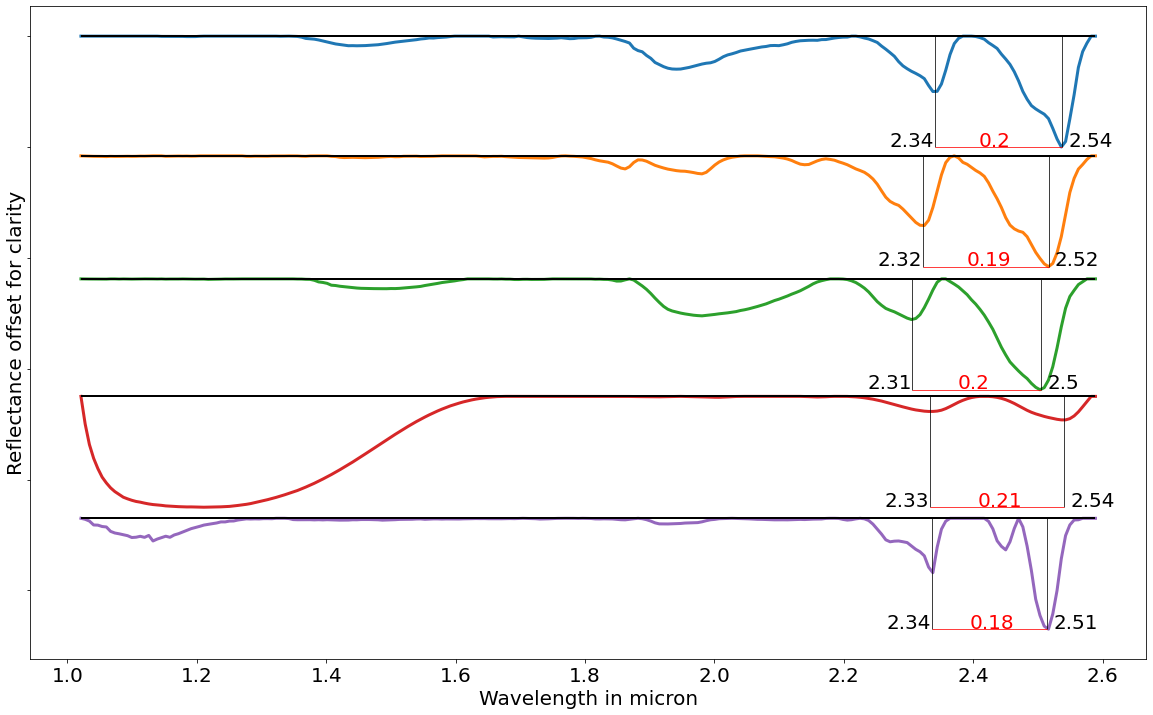

In [67]:
plt.figure(figsize=(20,12))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#iterate over all samples of current type
    

#get all samples
index=0
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
# set indices for carbonates to plot
carbonateIndices=[15,43,61,85,77]
#create a counter to be used to adjust multiplication for offset 
offset=[0,1.08,2.19,3.25,4.35]
offsetCounter=0
#iterate over all carbonate types
for i in carbonateIndices:
    currentSpectra=librarySpectras[i,:]
    #normalize spectra
    normalizedSpectra=normalizeSpectra(currentSpectra)
    #remove continuum
    crSpectra=plotHull(normalizedSpectra)
    #extract features
    features,wavelengths=getAbsorptionFeatures(crSpectra)
    #get spectral parameters
    bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)

    #variable to store index of 2.3 feature
    firstCO3FeatureIndex=-1
    #get no of features
    noOfFeatures=len(fwhms)
    #iterate over all features
    for k in range(noOfFeatures):
        if k<noOfFeatures-1 and bandCentres[k]<=bandCentre23UpperLimit and bandCentres[k]>=bandCentre23LowerLimit:
            firstCO3FeatureIndex=k
    #check if CO3 feature present
    if firstCO3FeatureIndex>=0:
        print(f"{j}--{(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])}--{bandCentres[firstCO3FeatureIndex]}--{bandCentres[firstCO3FeatureIndex+1]}")
        ibg=(bandCentres[firstCO3FeatureIndex+1]-bandCentres[firstCO3FeatureIndex])
        currentBC23=bandCentres[firstCO3FeatureIndex]
        currentBC25=bandCentres[-1]
        currentIBG=currentBC25-currentBC23
        minimumReflectance=np.min(plotHull(normalizeSpectra(librarySpectras[currentSampleIndex,:]))-offset[offsetCounter])
        maximumReflectance=1-offset[offsetCounter]
        
    plt.plot(wavelengthList,
             plotHull(normalizeSpectra(currentSpectra))-offset[offsetCounter],
             label=str(names[i][:names[i].index(' ')]),
             lw=3)
    plt.hlines(y=1-offset[offsetCounter],
               xmin=wavelengthList[0],
               xmax=wavelengthList[-1],
               lw=2,
               color='black')
    plt.vlines(x=currentBC23,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.vlines(x=currentBC25,
               ymax=maximumReflectance,
               ymin=minimumReflectance,
               lw=0.75,
               color='black')
    plt.hlines(y=minimumReflectance,
               xmin=currentBC23,
               xmax=currentBC25,
               lw=0.75,
               color='red')
    #plot inter-band gap
    plt.text(x=currentBC23+(currentBC25-currentBC23)/2-0.03,
             y=minimumReflectance+0.01,
             s=str(round(currentIBG,2)),
             fontsize=20,
             color='red')
    #plot 2.3 micron band-centre
    plt.text(x=currentBC23-0.07,
             y=minimumReflectance+0.01,
             s=str(round(currentBC23,2)),
             fontsize=20,
             color='black')
    #plot 2.5 micron band-centre
    plt.text(x=currentBC25+0.01,
             y=minimumReflectance+0.01,
             s=str(round(currentBC25,2)),
             fontsize=20,
             color='black')
    offsetCounter=offsetCounter+1

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` n

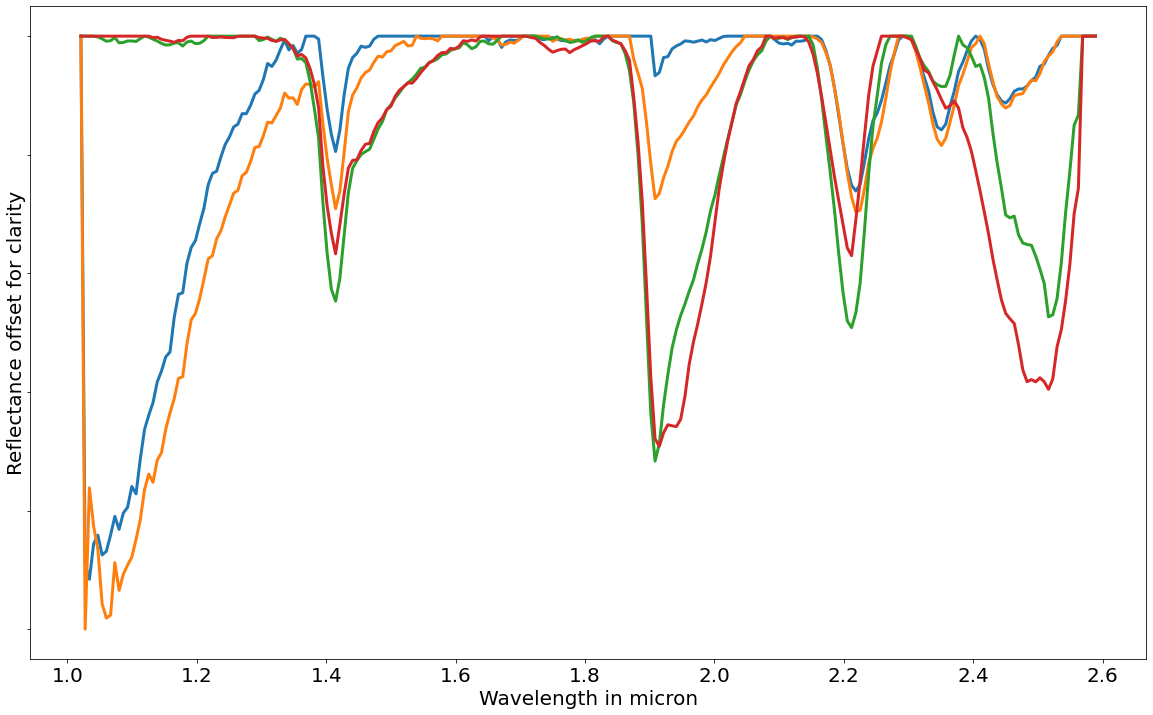

In [68]:
plt.figure(figsize=(20,12))
#add title
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#iterate over all samples of current type
#get all samples
index=6
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
for i in range(10,14):
    plt.plot(wavelengthList,plotHull(normalizeSpectra(librarySpectras[i,:])),lw=3)

PYROXENE C1PP16
MONTMORILLONITE C2JB36
JAROSITE N1CC11B


<Figure size 1440x864 with 0 Axes>

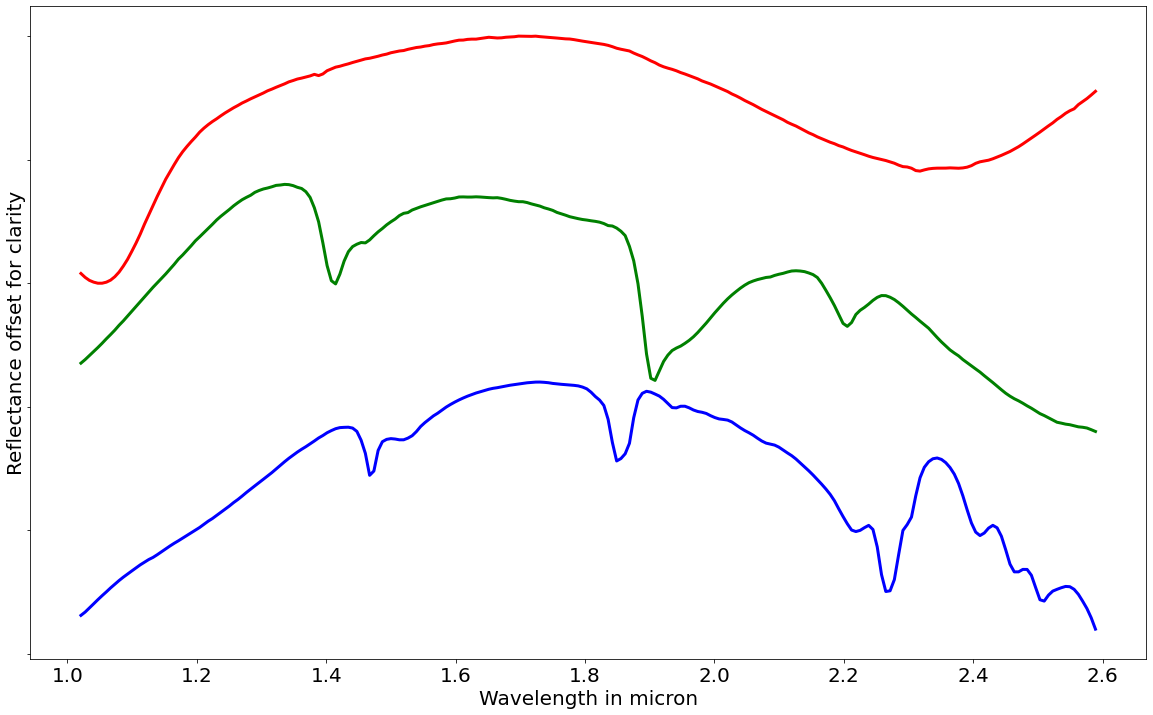

In [69]:
index=1
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
plt.figure(figsize=(20,12))
sampleIndices=[78,43,28]
mineralIndices=[1,6,-2]
offsets=[0,0.6,1.4]
colors=["red","green","blue","brown"]
index=-2
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
plt.figure(figsize=(20,12))
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#create variables to hold max and min limits
maximumY=-3
mininumY=3
for i in range(len(mineralIndices)):
    index=mineralIndices[i]
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    print(names[sampleIndices[i]])
    currentSpectra=librarySpectras[sampleIndices[i],:]
    normalizedSpectra=normalizeSpectra(currentSpectra)
    adjustedSpectra=normalizedSpectra-offsets[i]
    plt.plot(wavelengthList,adjustedSpectra,lw=3,color=colors[i])
    if maximumY<np.max(adjustedSpectra):
        maximumY=np.max(adjustedSpectra)
    if mininumY>=np.min(adjustedSpectra):
        mininumY=np.min(adjustedSpectra)


PYROXENE C1PP16


NameError: name 'startIndex' is not defined

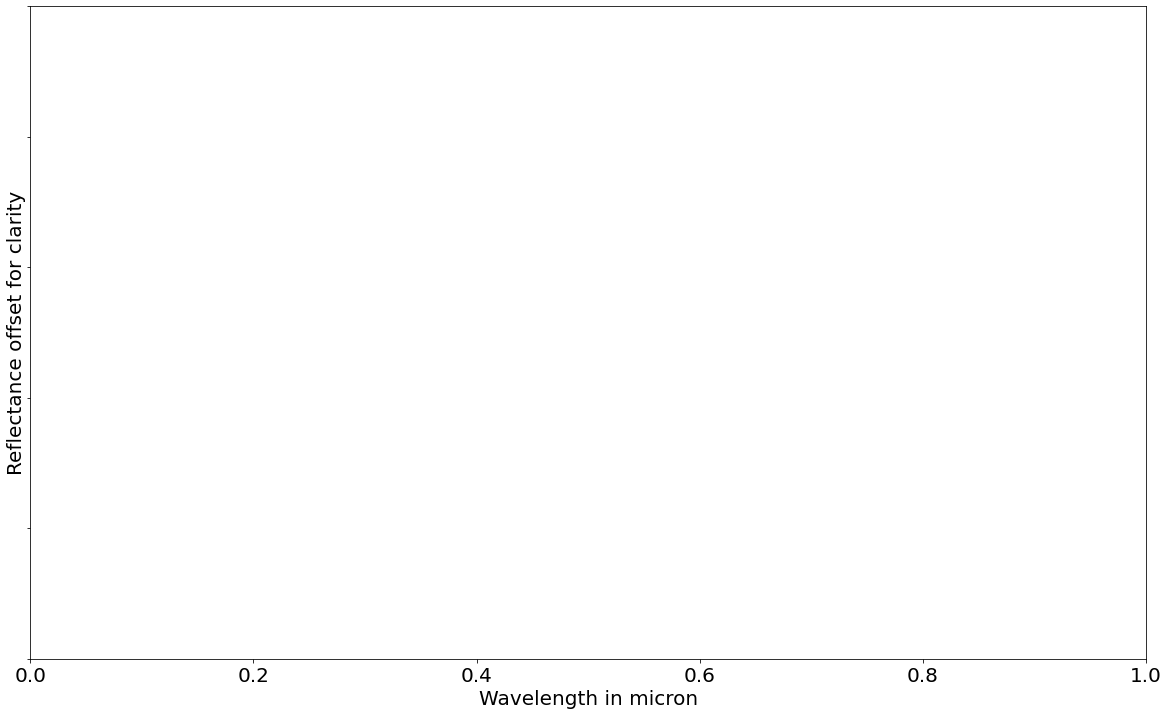

In [70]:

plt.figure(figsize=(20,12))
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#create variables to hold max and min limits
maximumY=-3
mininumY=3
for i in range(len(mineralIndices)):
    index=mineralIndices[i]
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    print(names[sampleIndices[i]])
    currentSpectra=librarySpectras[sampleIndices[i],:]
    normalizedSpectra=normalizeSpectra(currentSpectra)
    adjustedSpectra=normalizedSpectra-offsets[i]
    plt.plot(wavelengthList[startIndex:],(normalizedSpectra-offsets[i])[startIndex:],lw=3,color=colors[i])
    if maximumY<np.max(adjustedSpectra):
        maximumY=np.max(adjustedSpectra)
    if mininumY>=np.min(adjustedSpectra):
        mininumY=np.min(adjustedSpectra)

#add bandcentre lines
plt.vlines(x=2.295,ymax=maximumY,ymin=mininumY,linestyle="solid",lw=2,color="black")
plt.vlines(x=2.480,ymax=maximumY,ymin=mininumY,linestyle="solid",lw=2,color="black")
#add shoulders lines
plt.vlines(x=2.165,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
plt.vlines(x=2.364,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
plt.vlines(x=2.570,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
#get threshold for polygon
threshold=(wavelengthList[1]-wavelengthList[0])*2.5
#ply polygon band centres
plt.fill_between([2.295-threshold,2.295+threshold],mininumY,maximumY,color="orange",alpha=0.5)
plt.fill_between([2.480-threshold,2.480+threshold],mininumY,maximumY,color="orange",alpha=0.5)
#plot polygon shoulders
plt.fill_between([2.165-threshold,2.165+threshold],mininumY,maximumY,color="green",alpha=0.5)
plt.fill_between([2.364-threshold,2.364+threshold],mininumY,maximumY,color="green",alpha=0.5)
plt.fill_between([2.570-threshold,2.570+threshold],mininumY,maximumY,color="green",alpha=0.5)

#add maximmum
maximumY=maximumY+0.02
#add band centre text
plt.text(x=2.295,y=maximumY,s=str(2.295),fontsize=20,color="black")
plt.text(x=2.480,y=maximumY,s="2.480",fontsize=20,color="black")
#add shoulder text
plt.text(x=2.165,y=maximumY,s="2.165",fontsize=20,color="black")
plt.text(x=2.364,y=maximumY,s="2.364",fontsize=20,color="black")
plt.text(x=2.570,y=maximumY,s="2.570",fontsize=20,color="black")

PYROXENE C1PP16


NameError: name 'startIndex' is not defined

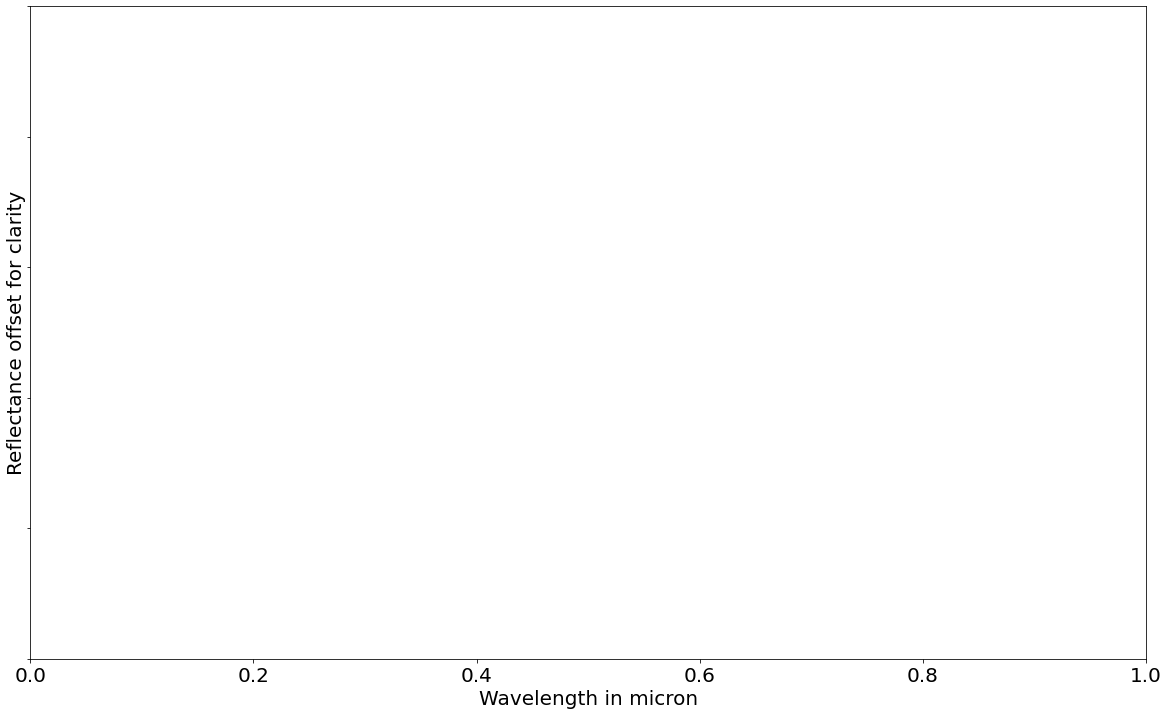

In [71]:

index=-2
librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
plt.figure(figsize=(20,12))
plt.title("",fontsize=20)
#add axis labels
plt.ylabel("Reflectance offset for clarity",fontsize=20)
plt.xlabel("Wavelength in micron",fontsize=20)
#add ticks on x-axis
plt.xticks(fontsize=20)
#add ticks on y-axis
plt.yticks(fontsize=20,visible=False)
#create variables to hold max and min limits
maximumY=-3
mininumY=3
for i in range(len(mineralIndices)):
    index=mineralIndices[i]
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    print(names[sampleIndices[i]])
    currentSpectra=librarySpectras[sampleIndices[i],:]
    normalizedSpectra=normalizeSpectra(currentSpectra)
    adjustedSpectra=normalizedSpectra-offsets[i]
    plt.plot(wavelengthList[startIndex:],(normalizedSpectra-offsets[i])[startIndex:],lw=3,color=colors[i])
    if maximumY<np.max(adjustedSpectra):
        maximumY=np.max(adjustedSpectra)
    if mininumY>=np.min(adjustedSpectra):
        mininumY=np.min(adjustedSpectra)
#add bandcentre lines
plt.vlines(x=2.345,ymax=maximumY,ymin=mininumY,linestyle="solid",lw=2,color="black")
plt.vlines(x=2.537,ymax=maximumY,ymin=mininumY,linestyle="solid",lw=2,color="black")
#add shoulders lines
plt.vlines(x=2.250,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
plt.vlines(x=2.430,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
plt.vlines(x=2.600,ymax=maximumY,ymin=mininumY,linestyle="dotted",lw=2,color="black")
#get threshold for polygon
threshold=(wavelengthList[1]-wavelengthList[0])*2.5
#ply polygon band centres
plt.fill_between([2.345-threshold,2.345+threshold],mininumY,maximumY,color="orange",alpha=0.5)
plt.fill_between([2.537-threshold,2.537+threshold],mininumY,maximumY,color="orange",alpha=0.5)
#plot polygon shoulders
plt.fill_between([2.250-threshold,2.250+threshold],mininumY,maximumY,color="green",alpha=0.5)
plt.fill_between([2.430-threshold,2.430+threshold],mininumY,maximumY,color="green",alpha=0.5)
plt.fill_between([2.600-threshold,2.600+threshold],mininumY,maximumY,color="green",alpha=0.5)

#add maximmum
maximumY=maximumY+0.02
#add band centre text
plt.text(x=2.345,y=maximumY,s=str(2.345),fontsize=20,color="black")
plt.text(x=2.537,y=maximumY,s="2.537",fontsize=20,color="black")
#add shoulder text
plt.text(x=2.250,y=maximumY,s="2.250",fontsize=20,color="black")
plt.text(x=2.430,y=maximumY,s="2.430",fontsize=20,color="black")
plt.text(x=2.600,y=maximumY,s="2.600",fontsize=20,color="black")

In [72]:

trueIndexCO3=0
trueIndexnonCO3=0
falseIndexCO3=0
falseIndexnonCO3=0
for index in range(len(spectralObjects)):
    #get spectra and sample names in the library
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    #get index corresponding to current mineral family using the name of the first sample
    currentFamilyIndex=firstSampleNames.index(names[0])
    #check which mineral family is being read 
    currentMineralFamily=mineralFamilies[currentFamilyIndex]
    #count number of Samples as total samples minus those to be ignores
    noOfSamples=len(names)-len(sampleIndicesToIgnore[currentFamilyIndex])
    #iterate over all samples in the current spectrabl object
    for sampleNumber in range(len(names)):
        #if the current sample is in the list of indices to be ignores continue or else process the sample
        if sampleNumber in sampleIndicesToIgnore[currentFamilyIndex]:
            continue
        #read the spectra at the current index
        currentSpectra=librarySpectras[sampleNumber,:]
        #normalize the spectra
        spectra=normalizeSpectra(currentSpectra)
        #read name of spectra
        spectraName=names[sampleNumber]
        #process the spectra to check if it is a carbonate 1,2 define type of carbonate, 0 means not carbonate
        cr=plotHull(spectra)
        features,wavelengths=getAbsorptionFeatures(cr)
        bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders=getFeatureParameters(wavelengths,features)
        carbonateFlag=checkForCarbonate(bandCentres,bandDepths,fwhms,leftShoulders,rightShoulders)
        #check if the sample is really a carbonate
        if currentMineralFamily=="carbonates":
            #check if sample is marked carbonate if so increment True positive counter
            if carbonateFlag!=0:
                trueIndexCO3=trueIndexCO3+1
            #else increment the false negetive counter
            else:
                falseIndexnonCO3=falseIndexnonCO3+1
        #if sample is not really a carbonate
        else:
            #check if sample is marked carbonate if so increment false positive counter
            if carbonateFlag!=0:
                falseIndexCO3=falseIndexCO3+1
            #else increment the true negetive counter
            else:
                trueIndexnonCO3=trueIndexnonCO3+1


#calculate accuracy parameters and record them
trueNegetiveStandard=trueIndexnonCO3
falseNegetiveStandard=falseIndexnonCO3
truePositiveStandard=trueIndexCO3
falsePositiveStandard=falseIndexCO3

print((truePositiveStandard/(truePositiveStandard+falseNegetiveStandard)))
print((trueNegetiveStandard/(trueNegetiveStandard+falsePositiveStandard)))
print(((truePositiveStandard+trueNegetiveStandard)/(trueNegetiveStandard+falsePositiveStandard+truePositiveStandard+falseNegetiveStandard)))

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


0.8620689655172413
0.9979381443298969
0.9772727272727273


In [73]:

trueIndexCO3=0
trueIndexnonCO3=0
falseIndexCO3=0
falseIndexnonCO3=0
for index in range(len(spectralObjects)):
    #get spectra and sample names in the library
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    #get index corresponding to current mineral family using the name of the first sample
    currentFamilyIndex=firstSampleNames.index(names[0])
    #check which mineral family is being read 
    currentMineralFamily=mineralFamilies[currentFamilyIndex]
    #count number of Samples as total samples minus those to be ignores
    noOfSamples=len(names)-len(sampleIndicesToIgnore[currentFamilyIndex])
    #iterate over all samples in the current spectrabl object
    for sampleNumber in range(len(names)):
        #if the current sample is in the list of indices to be ignores continue or else process the sample
        if sampleNumber in sampleIndicesToIgnore[currentFamilyIndex]:
            continue
        #read the spectra at the current index
        currentSpectra=librarySpectras[sampleNumber,:]
        #normalize the spectra
        spectra=normalizeSpectra(currentSpectra)
        #read name of spectra
        spectraName=names[sampleNumber]
        #process the spectra to check if it is a carbonate 1,2 define type of carbonate, 0 means not carbonate
        MIN2295_2480,MIN2345_2537=calculateCarbonateBandDepthIndicesForSpectra(plotHull(spectra))
        carbonateFlag=0
        if max(MIN2295_2480,MIN2345_2537)>=0.08:
            carbonateFlag=1
        #check if the sample is really a carbonate
        if currentMineralFamily=="carbonates":
            #check if sample is marked carbonate if so increment True positive counter
            if carbonateFlag!=0:
                trueIndexCO3=trueIndexCO3+1
            #else increment the false negetive counter
            else:
                falseIndexnonCO3=falseIndexnonCO3+1
        #if sample is not really a carbonate
        else:
            #check if sample is marked carbonate if so increment false positive counter
            if carbonateFlag!=0:
                falseIndexCO3=falseIndexCO3+1
            #else increment the true negetive counter
            else:
                trueIndexnonCO3=trueIndexnonCO3+1


#calculate accuracy parameters and record them
trueNegetiveStandard=trueIndexnonCO3
falseNegetiveStandard=falseIndexnonCO3
truePositiveStandard=trueIndexCO3
falsePositiveStandard=falseIndexCO3

print((truePositiveStandard/(truePositiveStandard+falseNegetiveStandard)))
print((trueNegetiveStandard/(trueNegetiveStandard+falsePositiveStandard)))
print(((truePositiveStandard+trueNegetiveStandard)/(trueNegetiveStandard+falsePositiveStandard+truePositiveStandard+falseNegetiveStandard)))

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


0.7241379310344828
0.9175257731958762
0.8881118881118881


In [90]:

trueIndexCO3=0
trueIndexnonCO3=0
falseIndexCO3=0
falseIndexnonCO3=0
for index in range(len(spectralObjects)):
    #get spectra and sample names in the library
    librarySpectras,names=getResampledSpectra(spectralObjects[index],wavelengthList)
    #get index corresponding to current mineral family using the name of the first sample
    currentFamilyIndex=firstSampleNames.index(names[0])
    #check which mineral family is being read 
    currentMineralFamily=mineralFamilies[currentFamilyIndex]
    #count number of Samples as total samples minus those to be ignores
    noOfSamples=len(names)-len(sampleIndicesToIgnore[currentFamilyIndex])
    #iterate over all samples in the current spectrabl object
    for sampleNumber in range(len(names)):
        #if the current sample is in the list of indices to be ignores continue or else process the sample
        if sampleNumber in sampleIndicesToIgnore[currentFamilyIndex]:
            continue
        #read the spectra at the current index
        currentSpectra=librarySpectras[sampleNumber,:]
        #normalize the spectra
        spectra=normalizeSpectra(currentSpectra)
        #read name of spectra
        spectraName=names[sampleNumber]
        #process the spectra to check if it is a carbonate 1,2 define type of carbonate, 0 means not carbonate
        MIN2295_2480,MIN2345_2537=calculateCarbonateBandDepthIndicesForSpectra(plotHull(spectra))
        D2300,BS2355,BD2290,BD2500_2=calculateAdditionalCarbonteBandDepthIndicesForSpectra(plotHull(spectra),wavelengthList)
        #print(f"{index}-\t-{sampleNumber}-\t-{spectraName[:spectraName.index(' ')]}-\t- {MIN2295_2480}-\t- {MIN2345_2537}-\t- {D2300}-\t- {BS2355}-\t- {BD2290}-\t- {BD2500_2}")
        print(f"{index}-\t-{sampleNumber}-\t-{spectraName[:spectraName.index(' ')]}-\t- {max(MIN2295_2480,MIN2345_2537,BD2500_2)}")
        carbonateFlag=0
        if max(MIN2295_2480,MIN2345_2537)>=0.08:
            carbonateFlag=1
        #check if the sample is really a carbonate
        if currentMineralFamily=="carbonates":
            #check if sample is marked carbonate if so increment True positive counter
            if carbonateFlag!=0:
                trueIndexCO3=trueIndexCO3+1
            #else increment the false negetive counter
            else:
                falseIndexnonCO3=falseIndexnonCO3+1
        #if sample is not really a carbonate
        else:
            #check if sample is marked carbonate if so increment false positive counter
            if carbonateFlag!=0:
                falseIndexCO3=falseIndexCO3+1
            #else increment the true negetive counter
            else:
                trueIndexnonCO3=trueIndexnonCO3+1


#calculate accuracy parameters and record them
trueNegetiveStandard=trueIndexnonCO3
falseNegetiveStandard=falseIndexnonCO3
truePositiveStandard=trueIndexCO3
falsePositiveStandard=falseIndexCO3

print((truePositiveStandard/(truePositiveStandard+falseNegetiveStandard)))
print((trueNegetiveStandard/(trueNegetiveStandard+falsePositiveStandard)))
print(((truePositiveStandard+trueNegetiveStandard)/(trueNegetiveStandard+falsePositiveStandard+truePositiveStandard+falseNegetiveStandard)))

C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:3: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c1=ndimage.filters.uniform_filter(signal,windowSize, mode='reflect')
C:\Users\104D\AppData\Local\Temp/ipykernel_5084/344975919.py:4: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  c2=ndimage.filters.uniform_filter(signal*signal,windowSize, mode='reflect')


0-	-0-	-ANKERITE-	- 0.15530076511682966
0-	-1-	-ANKERITE-	- 0.07252212028360361
0-	-2-	-ANKERITE-	- 0.09777792107302374
0-	-3-	-ANKERITE-	- 0.06945390512572747
0-	-4-	-ANKERITE-	- 0.08184552940712553
0-	-5-	-ANKERITE-	- 0.04345153381126099
0-	-6-	-ARAGONITE-	- 0.3731847320310755
0-	-7-	-ARAGONITE-	- 0.36316071939174654
0-	-8-	-ARAGONITE-	- 0.3888865388360476
0-	-9-	-ARAGONITE-	- 0.3728404475178392
0-	-10-	-ARAGONITE-	- 0.3888988924336265
0-	-11-	-ARAGONITE-	- 0.37284031236922355
0-	-12-	-CALCITE-	- 0.4870070204120057
0-	-13-	-CALCITE-	- 0.46851090949279495
0-	-15-	-CALCITE-	- 0.433443031761759
0-	-16-	-CALCITE-	- 0.890197029698871
0-	-17-	-CALCITE-	- 0.502836090363685
0-	-18-	-CALCITE-	- 0.4990842458648924
0-	-19-	-CALCITE-	- 0.45740769413138593
0-	-20-	-CALCITE-	- 0.49657529500576914
0-	-21-	-CALCITE-	- 0.48492184190893606
0-	-22-	-CALCITE-	- 0.46851485394271886
0-	-23-	-CALCITE-	- 0.5663257427389059
0-	-24-	-CALCITE-	- 0.5349488975000201
0-	-25-	-CALCITE-	- 0.5056019263029436
0-	-26-

1-	-129-	-PYROXENE-	- 0.043058602239324006
1-	-130-	-PYROXENE-	- 0.0050255715682273605
1-	-131-	-PYROXENE-	- 0.005849746506702891
1-	-132-	-PYROXENE-	- 0.0011042805436612957
1-	-133-	-PYROXENE-	- -0.01426463175051107
1-	-134-	-PYROXENE-	- -0.027718348514502056
1-	-135-	-PYROXENE-	- -0.039882601194292544
1-	-136-	-PYROXENE-	- 0.005127972249000301
1-	-137-	-PYROXENE-	- 0.00206873714750333
1-	-138-	-PYROXENE-	- 0.03362915790533039
1-	-139-	-PYROXENE-	- -0.0018002154775909052
1-	-141-	-PYROXMANGITE-	- 0.040242562157411954
1-	-142-	-RHODONITE-	- -0.017617584760828864
1-	-144-	-WOLLASTONITE-	- -0.019773795849852727
1-	-145-	-WOLLASTONITE-	- 0.036832869406554836
2-	-0-	-CHRYSOLITE-	- 0.0034862021364235884
2-	-1-	-CHRYSOLITE-	- 0.004201747170645809
2-	-2-	-CHRYSOLITE-	- 0.005736932463443756
2-	-3-	-CHRYSOLITE-	- 0.012440111319030556
2-	-4-	-FAYALITE-	- 0.0018457859152930522
2-	-5-	-FAYALITE-	- 0.0023093863110104085
2-	-6-	-FAYALITE-	- -0.00015311674399942632
2-	-7-	-FORSTERITE-	- 0.00282378608

6-	-44-	-MONTMORILLONITE-	- 0.18880350645549182
6-	-45-	-MONTMORILLONITE-	- 0.29805474715260294
6-	-46-	-MONTMORILLONITE-	- 0.0863183553631729
6-	-47-	-MONTMORILLONITE-	- 0.26490642332335856
6-	-48-	-MONTMORILLONITE-	- 0.07325921096283616
6-	-49-	-NONTRONITE-	- -0.09514899896846551
6-	-50-	-NONTRONITE-	- -0.05441038467459958
6-	-51-	-NONTRONITE-	- 0.1366547642240976
6-	-52-	-NONTRONITE-	- 0.05062962552914374
6-	-53-	-NONTRONITE-	- 0.0459340941722024
6-	-54-	-NONTRONITE-	- 0.021504005718485986
6-	-55-	-PALAGONITE-	- -0.049364398522157904
6-	-56-	-PALAGONITE-	- -0.06044091678357044
6-	-57-	-PYROPHYLLITE-TALC-	- 0.04673225524449198
6-	-58-	-PYROPHYLLITE-TALC-	- -0.029096700906384276
6-	-59-	-SAPONITE-	- -0.4043036114332752
6-	-60-	-SAPONITE-	- -0.3917521418944565
6-	-61-	-SAPONITE-	- -0.03571594503848674
6-	-62-	-SAPONITE-	- 0.22673276382713425
6-	-63-	-SAPONITE-	- -0.06935335789972297
6-	-64-	-SAPONITE-	- 0.056521708490271605
6-	-66-	-SERPENTINE-	- 0.028519612473444478
6-	-67-	-SERPENTIN